<a href="https://colab.research.google.com/github/WinetraubLab/3D-segmentation/blob/main/3D-segmentation.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
<a href="https://github.com/WinetraubLab/3D-segmentation/blob/main/3D-segmentation.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

#   Segmentation with MedSAM2
Use MedSAM2 to automatically detect classes and segment a stack of OCT images.

Make sure to use a GPU runtime (T4 on Colab).
> **Runtime → Change runtime type → GPU**  

INPUTS:
1. Roboflow dataset of OCT images with annotations. Each annotation mask is a complete segmentation of one instance of the specified class.
2. Folder containing OCT images to be segmented using this script.

OUTPUTS: A folder containing segmentation mask images for each frame.


## Setup and Dependencies

In [ ]:
!git clone https://github.com/WinetraubLab/3D-segmentation.git
!pip install -r 3D-segmentation/requirements.txt

In [ ]:
!git clone https://github.com/bowang-lab/MedSAM2.git
%cd MedSAM2
!sh download.sh

In [ ]:
# @title Configuration and Dataset
import os
from roboflow import Roboflow
from google.colab import files
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
import shutil

import sys
sys.path.append('/content/3D-segmentation')

import import_data_from_roboflow, propagate_mask_medsam2, export_coco

drive.mount('/content/drive')

# LOAD ROBOFLOW DATA
# @markdown Enter the directory containing your image stack to segment:
image_dataset_folder_path = "/content/images/test" # @param {type:"string"}

if not os.path.isdir(image_dataset_folder_path):
    raise NotADirectoryError(f"‘{image_dataset_folder_path}’ is not a valid directory")

# @markdown **If loading segmentations from Roboflow:** Enter your Roboflow API key, and details of the dataset with your annotated images. Otherwise, leave this blank.
workspace_name = "yolab-kmmfx"  # @param {type:"string"}
project_name = "vol1z"  # @param {type:"string"}
# @markdown For example: workspace_name="yolab-kmmfx"; project_name="vol1_2"

# @markdown **If loading segmentations from folder:** Enter the path to the folder containing COCO .json file with annotation data. Otherwise, leave this blank.
segmentation_data_path = ""  # @param {type:"string"}

if segmentation_data_path:
    class_ids = import_data_from_roboflow.init_from_folder(segmentation_data_path)
else:
    # Get API key from credentials sheet to load data

    filepath = "/content/drive/Shareddrives/Yolab - Current Projects/_Components and General Protocols/Credentials/roboflow_api_key.txt"
    with open(filepath) as f:
        api_key = f.read()
    if not api_key:
        print("Could not find API key.")

class_ids = import_data_from_roboflow.init_from_roboflow(workspace_name, project_name, api_key)

MODEL_CONFIG = "configs/sam2.1_hiera_t512.yaml"
MODEL_CHECKPOINT = "checkpoints/MedSAM2_latest.pt"

In [ ]:
# @title Initialize and run model

"""Note: if Colab RAM limit is exceeded, set downsample_hw_size=(500,500)"""
downsample_2d_size = None

# Preprocess images
preprocessed_images_path = "/content/preprocessed_images/"
import_data_from_roboflow.preprocess_images(image_dataset_folder_path, preprocessed_images_path, downsample_hw_size=downsample_2d_size)

# Run model
model = propagate_mask_medsam2.CustomMEDSAM2(MODEL_CONFIG, MODEL_CHECKPOINT)

indiv_class_masks = []
frame_names = import_data_from_roboflow.list_all_images()
binary_segmentations = np.empty(len(frame_names), dtype=object)
binary_segmentations[:] = None

for class_id in class_ids:
    # construct segmentations for this class
    binary_segmentations = import_data_from_roboflow.create_mask_volume(class_id, downsample_hw_size=downsample_2d_size)
    class_mask = model.propagate(preprocessed_images_path, binary_segmentations, sigma_xy=0.8, sigma_z=0.8)
    indiv_class_masks.append(class_mask)

Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
frame loading (JPEG): 100%|██████████| 134/134 [00:01<00:00, 81.51it/s]
/content/MedSAM2/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
frame loading (JPEG): 100%|██████████| 134/134 [00:01<00:00, 85.00it/s]


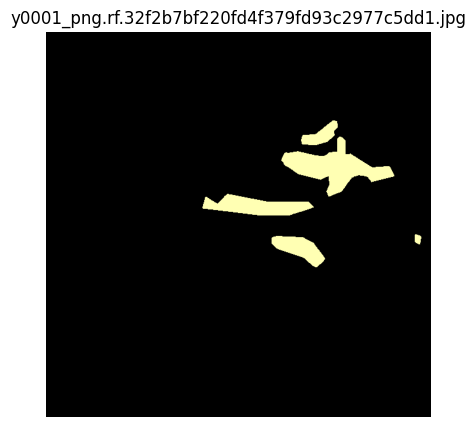

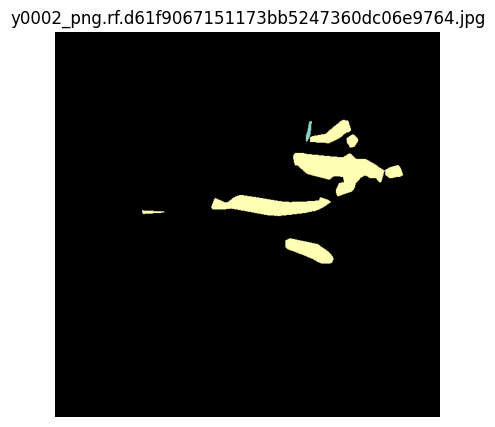

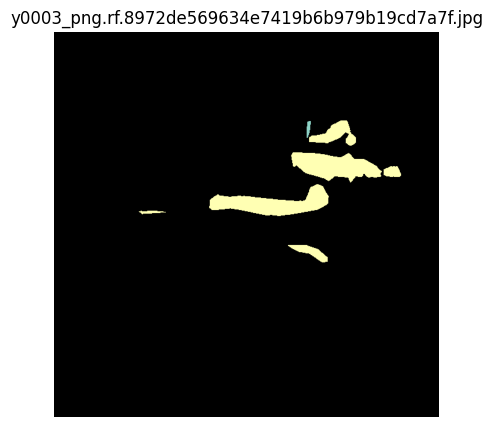

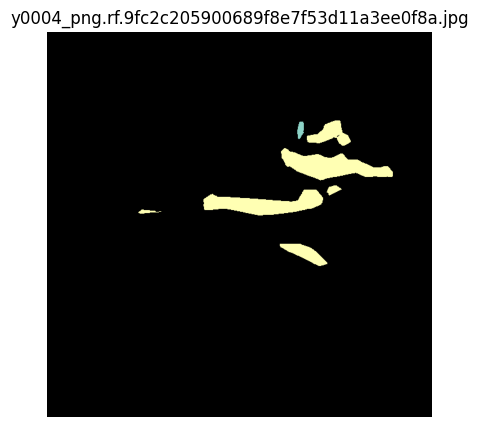

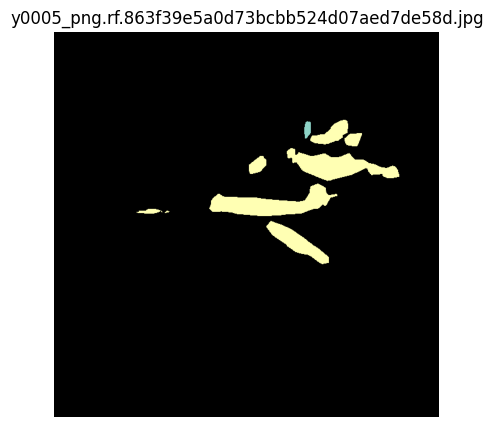

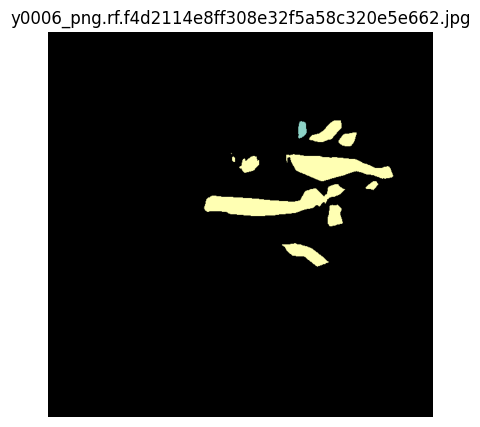

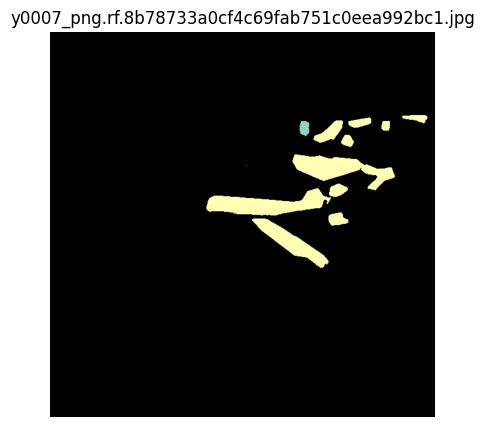

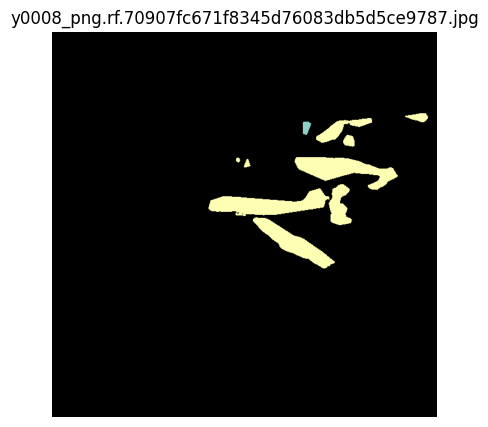

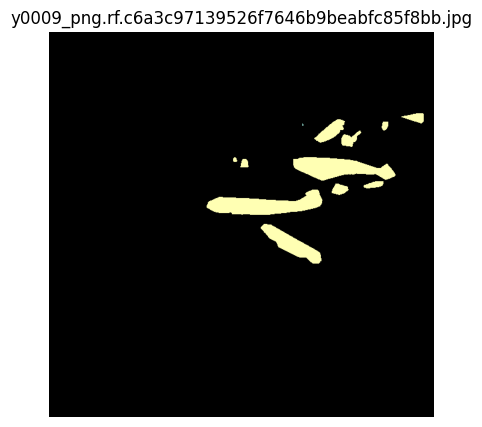

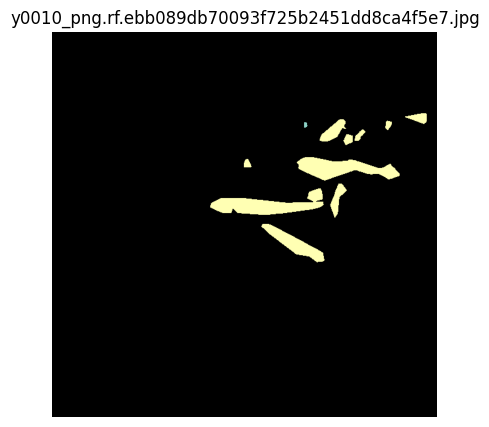

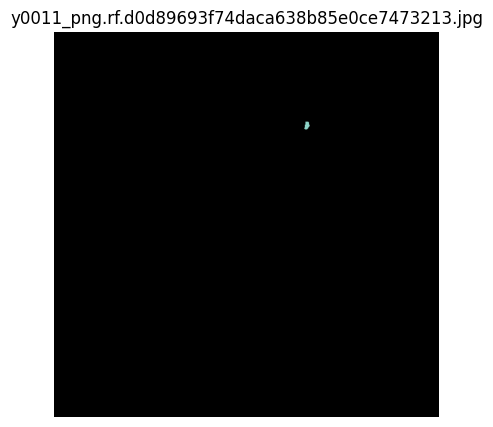

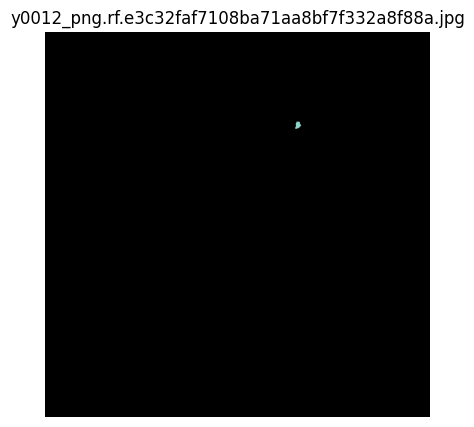

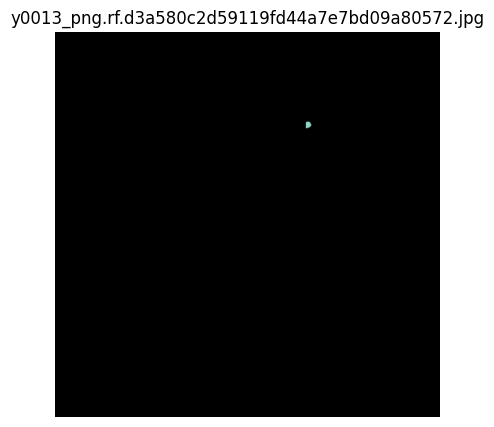

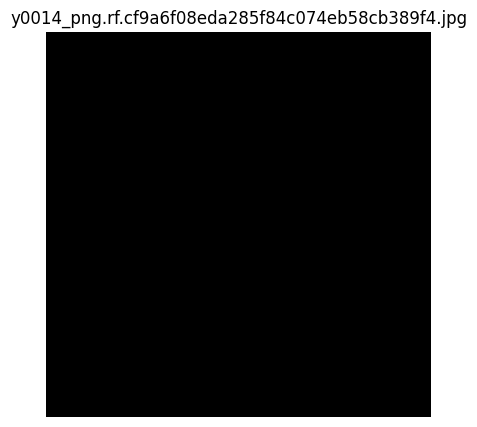

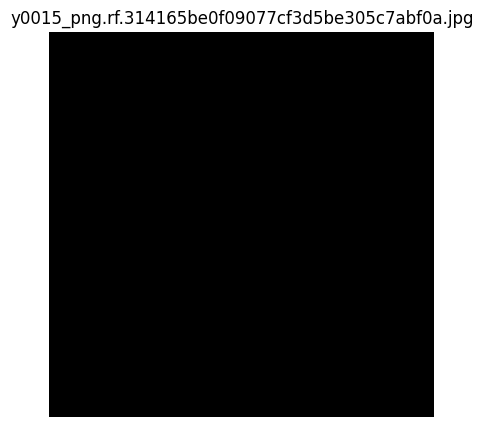

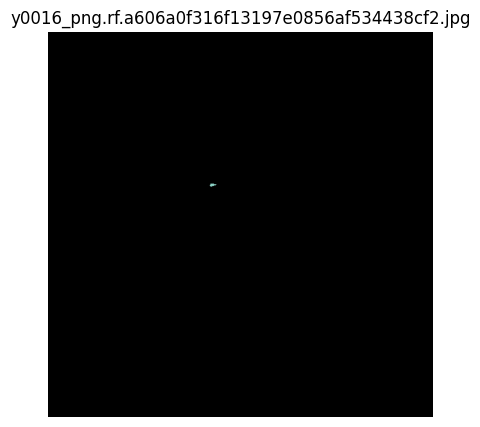

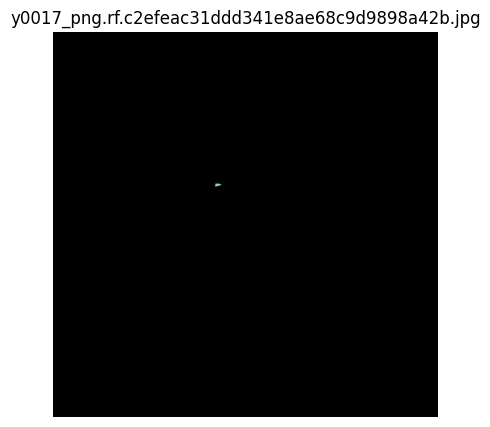

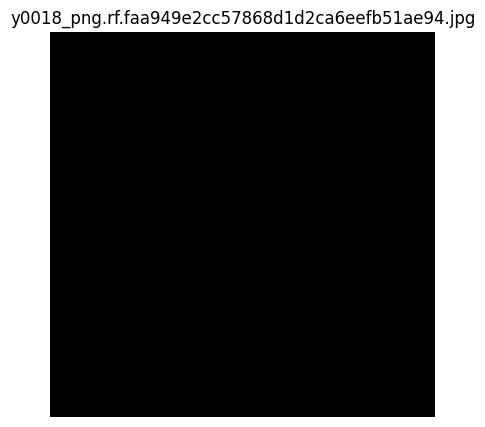

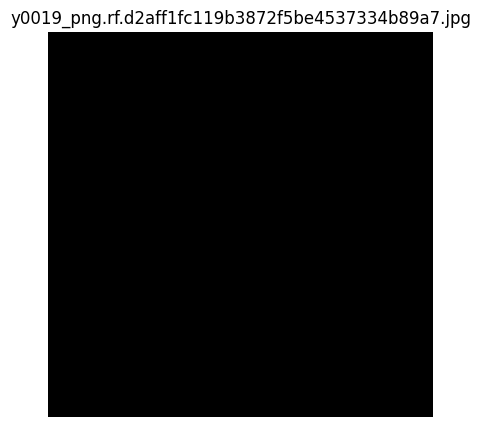

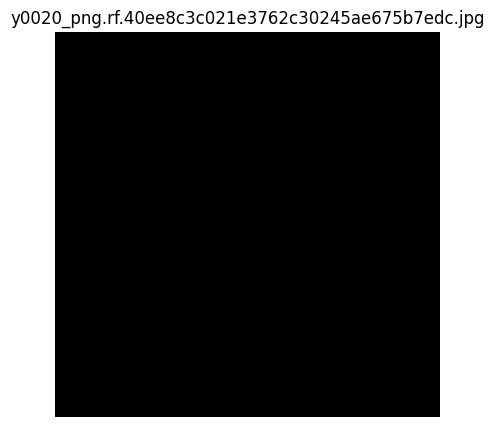

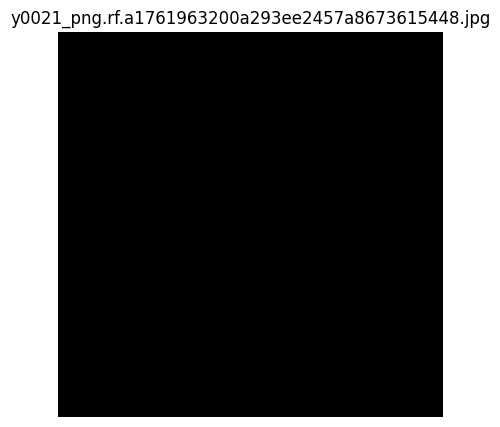

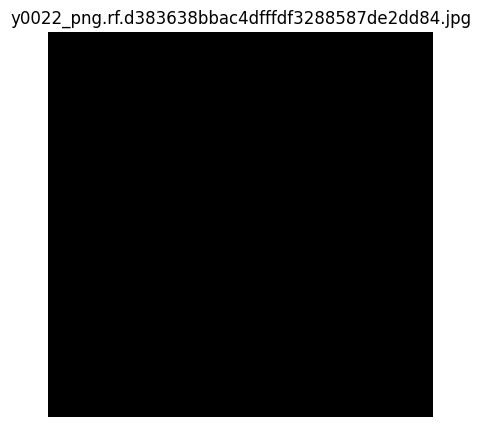

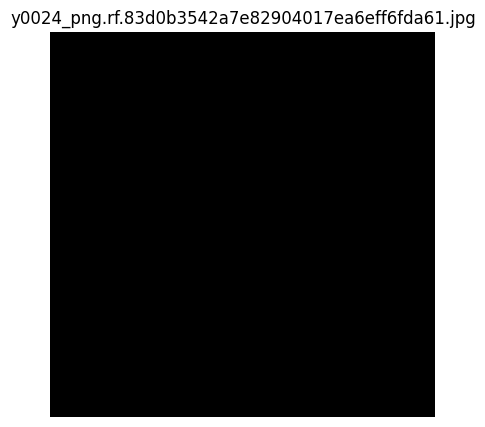

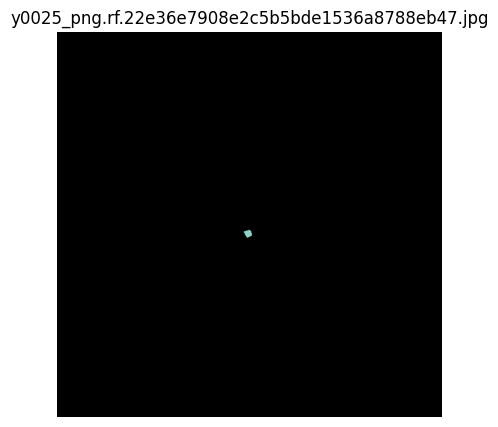

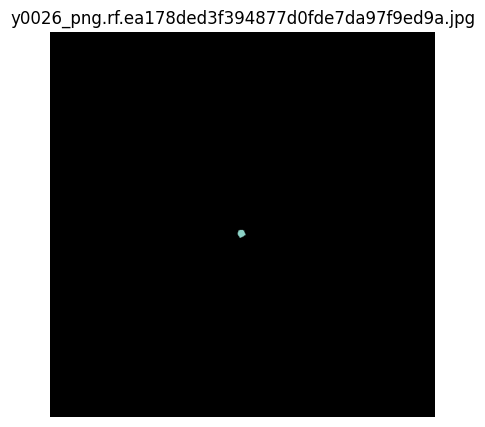

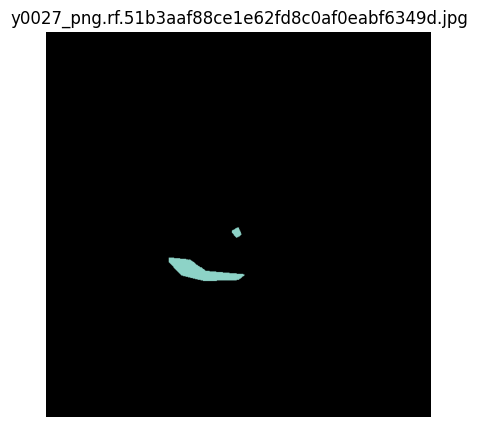

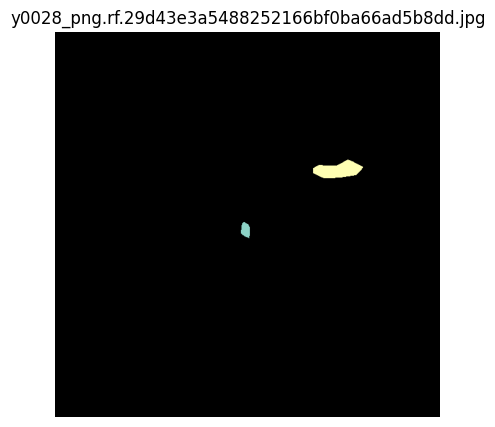

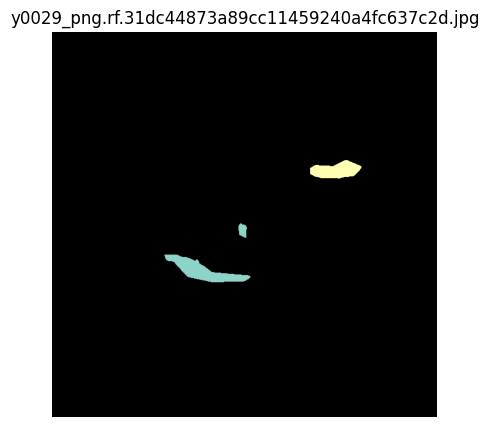

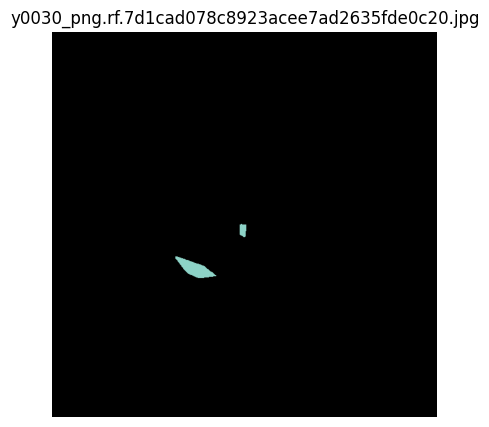

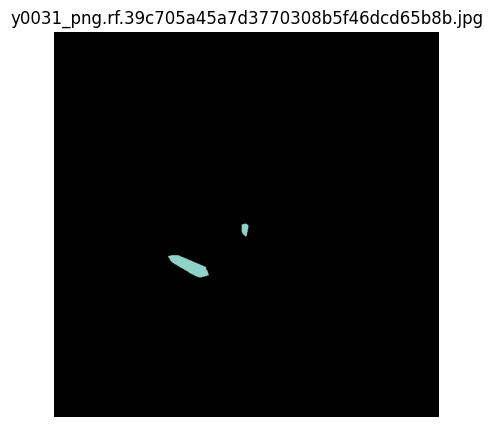

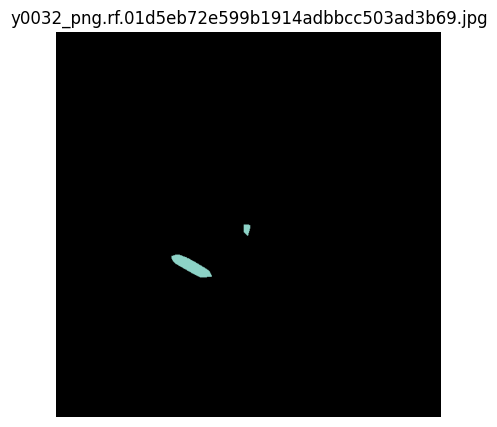

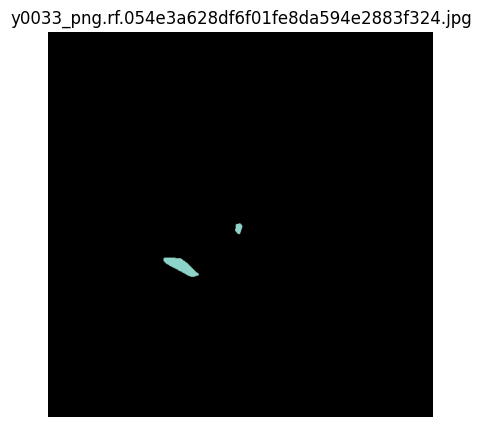

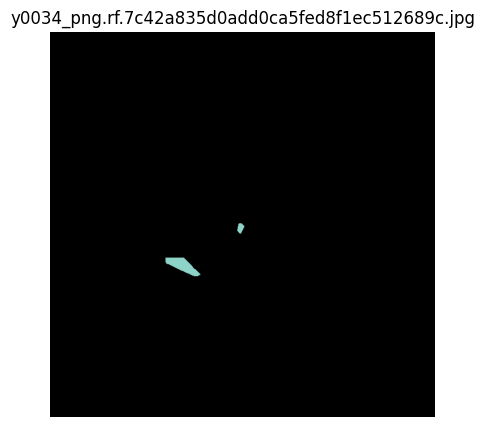

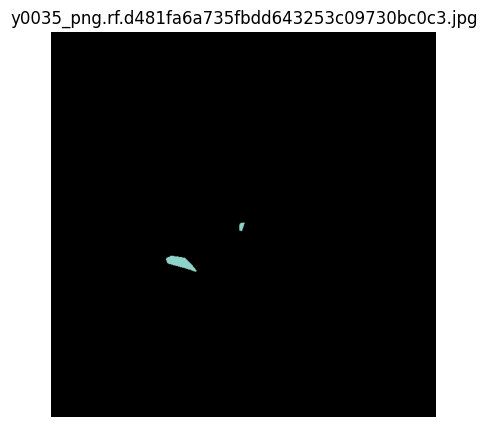

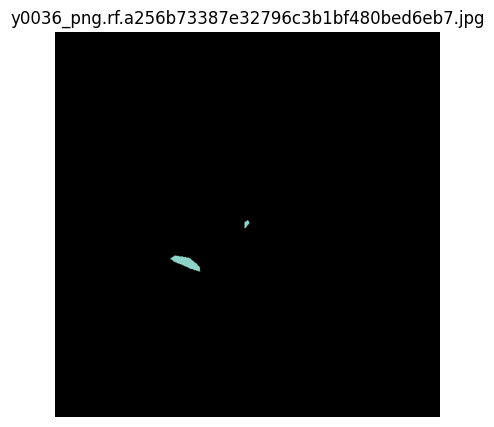

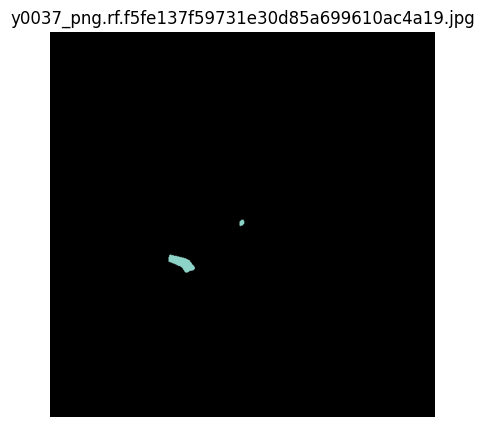

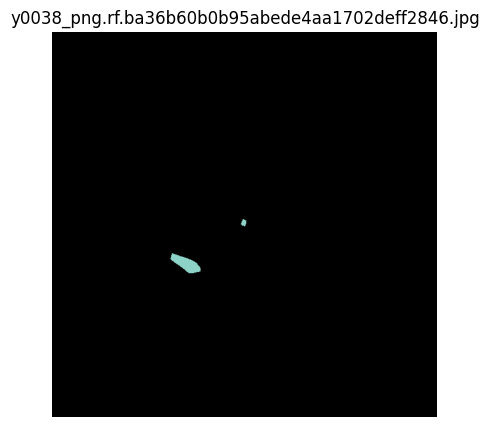

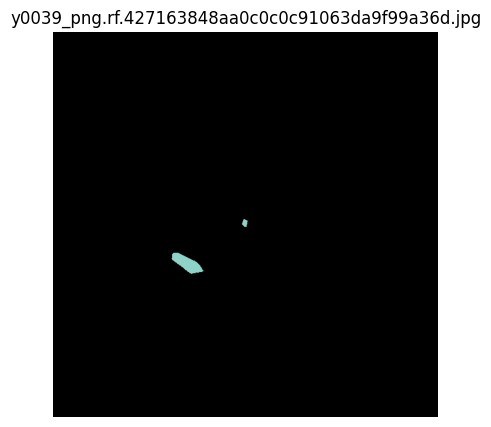

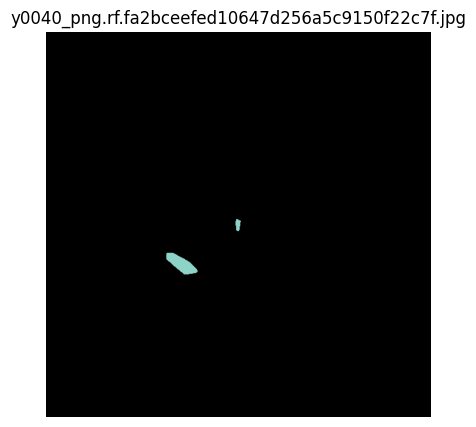

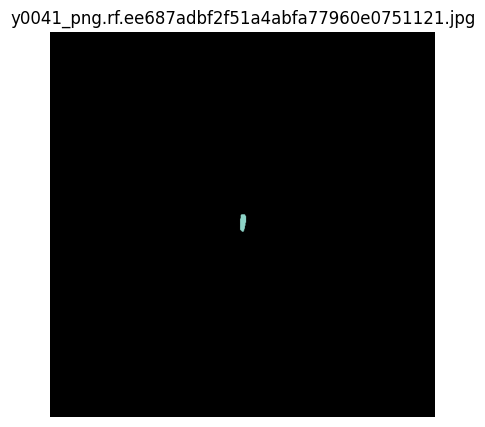

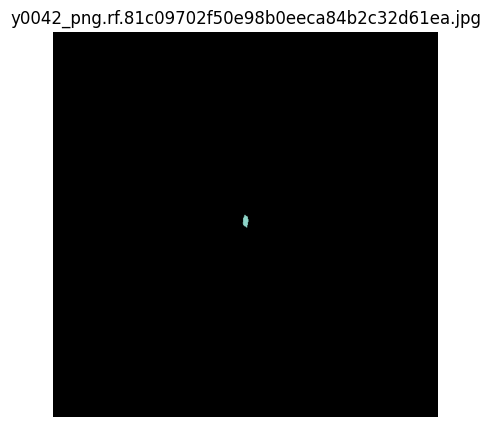

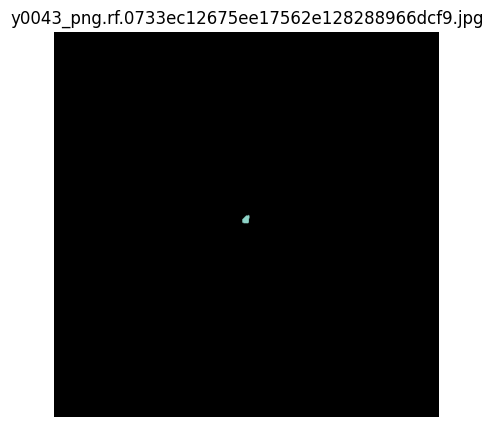

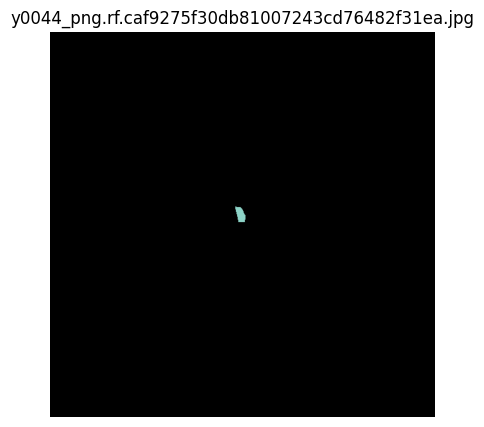

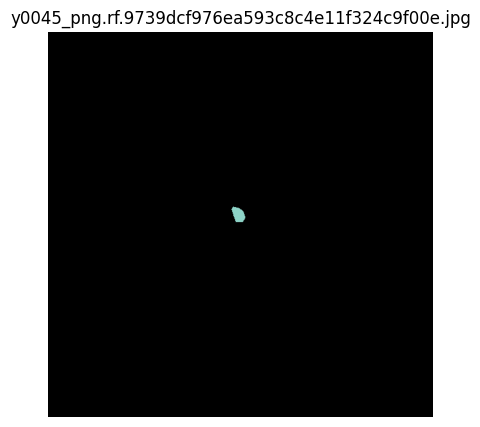

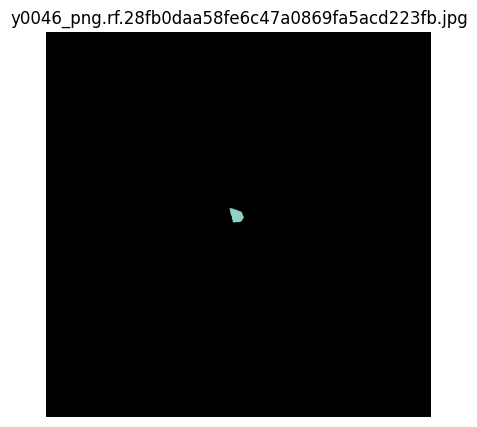

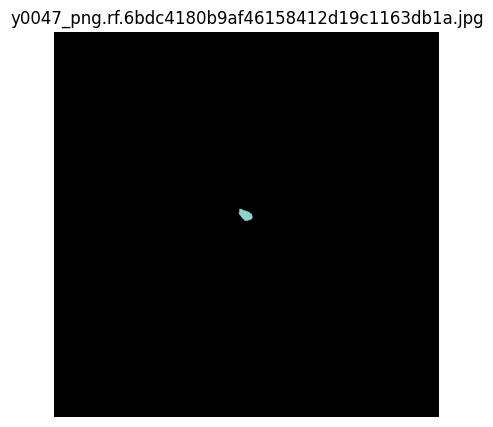

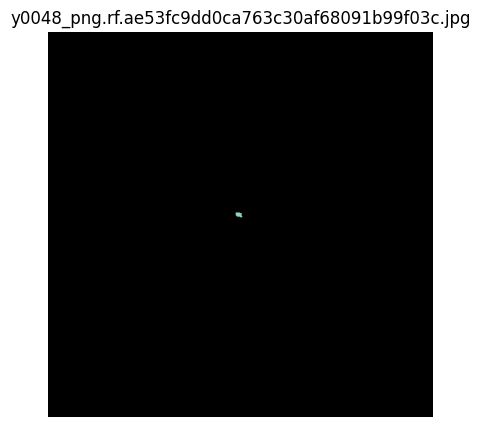

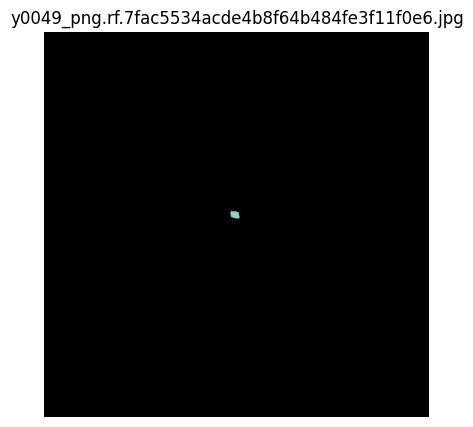

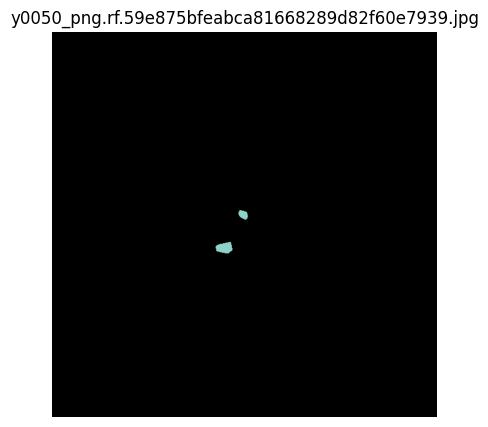

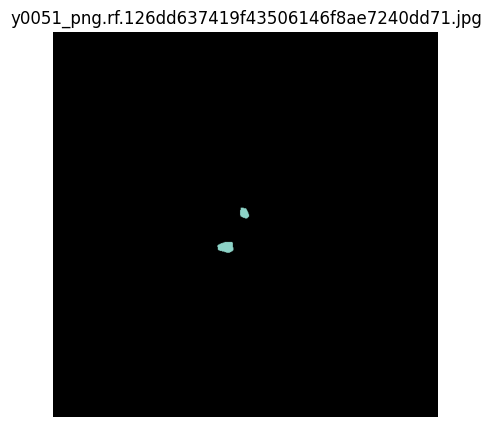

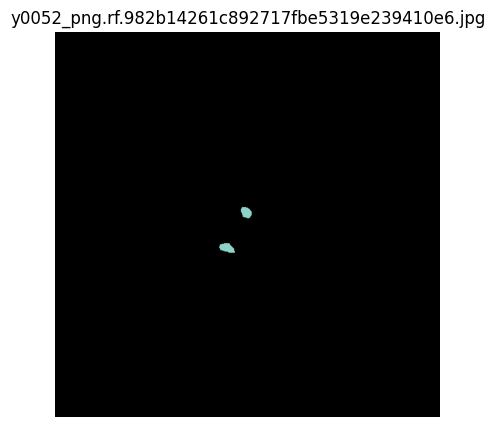

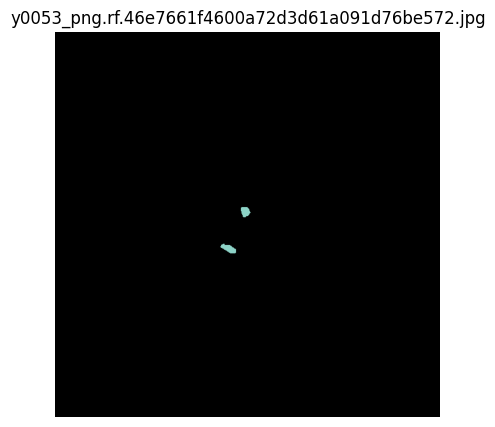

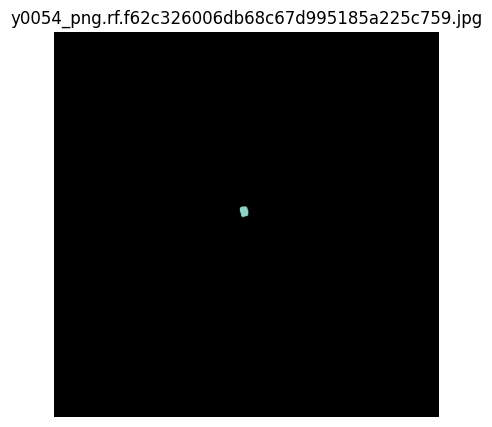

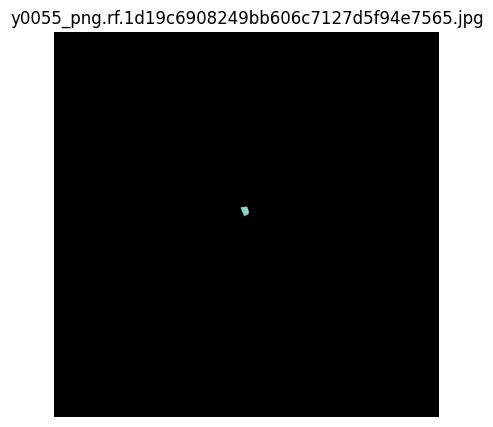

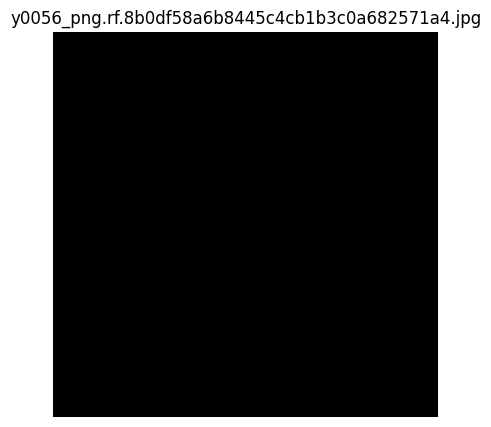

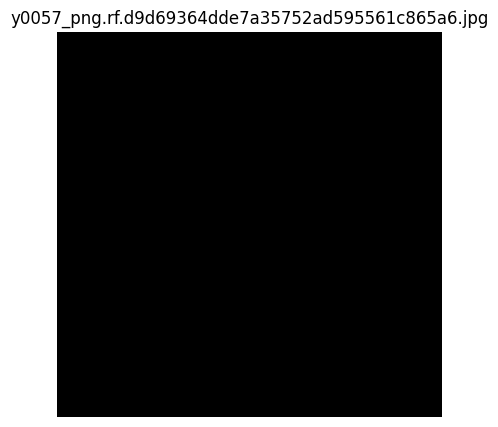

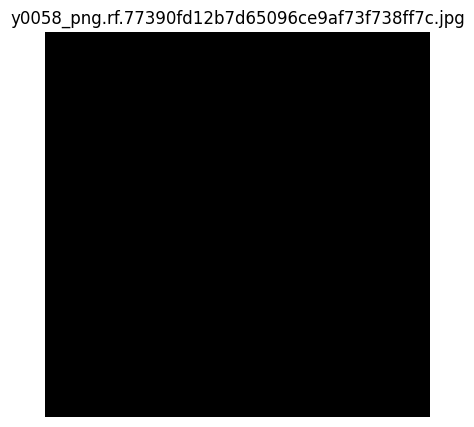

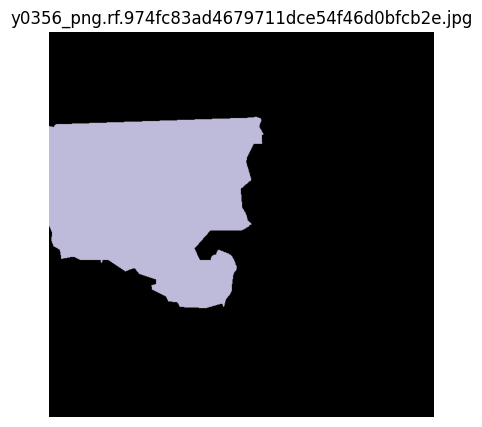

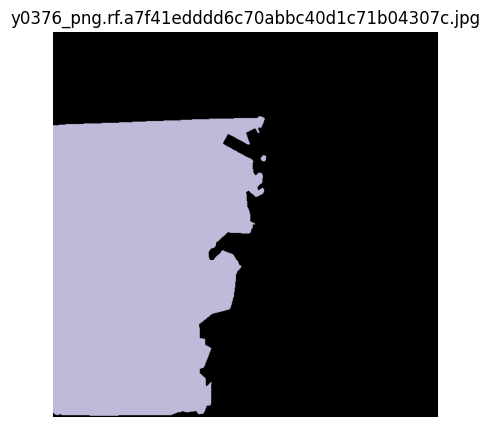

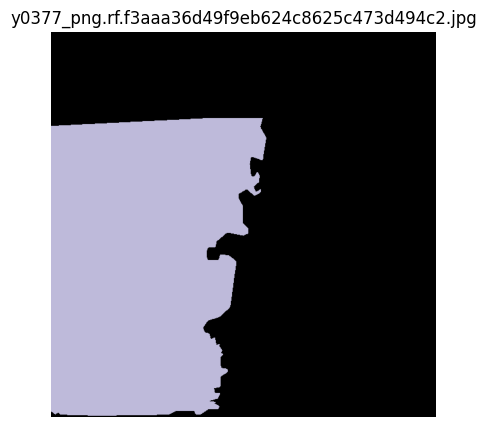

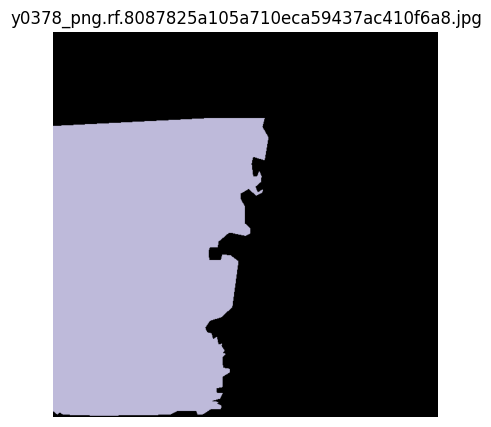

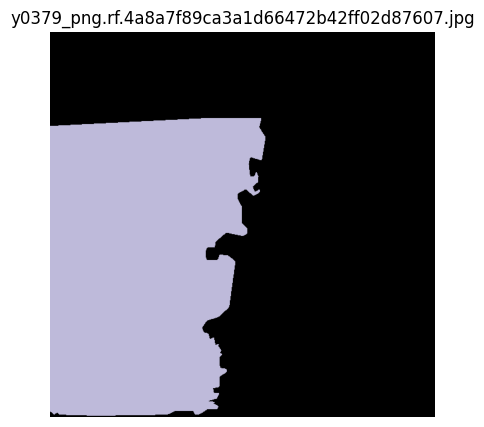

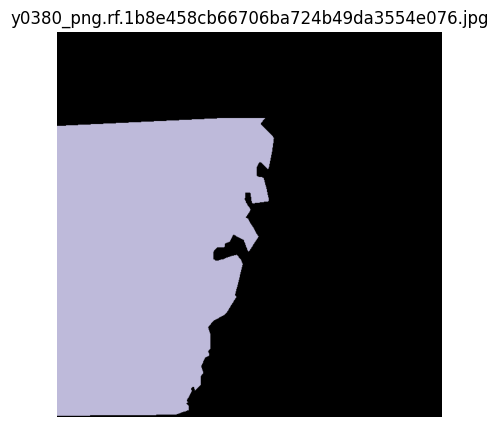

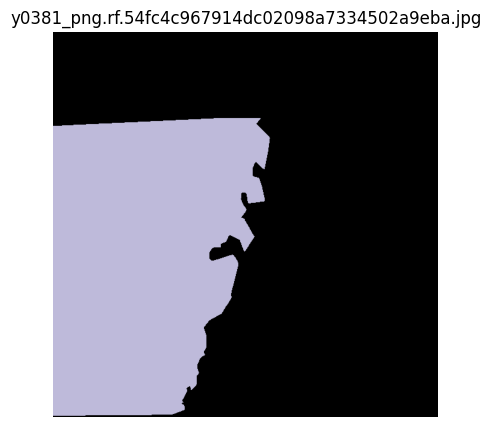

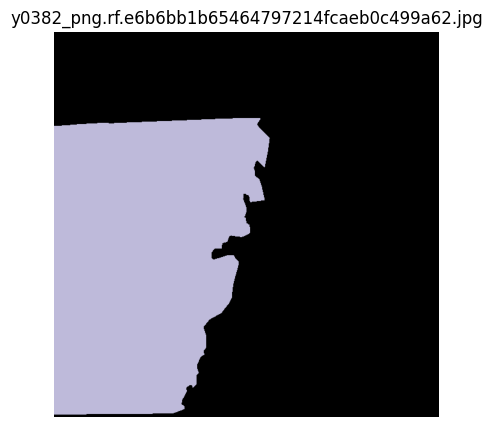

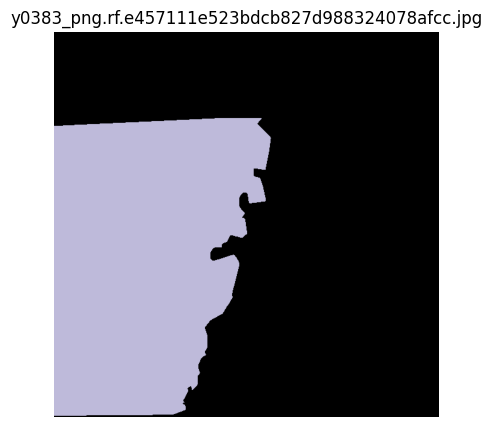

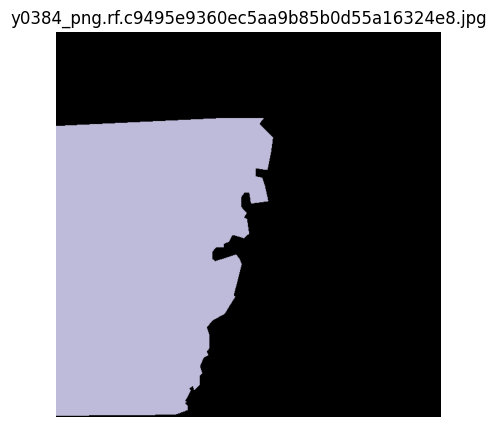

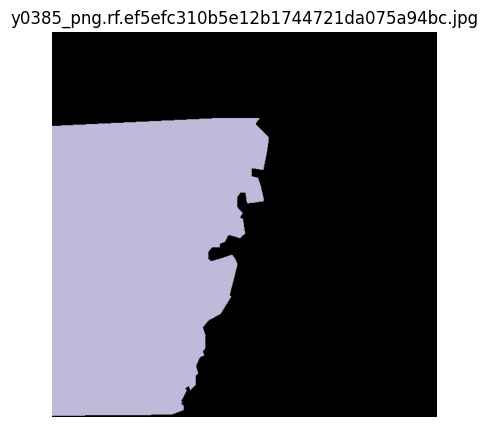

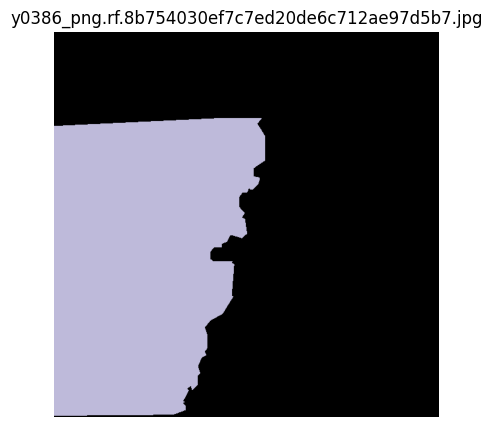

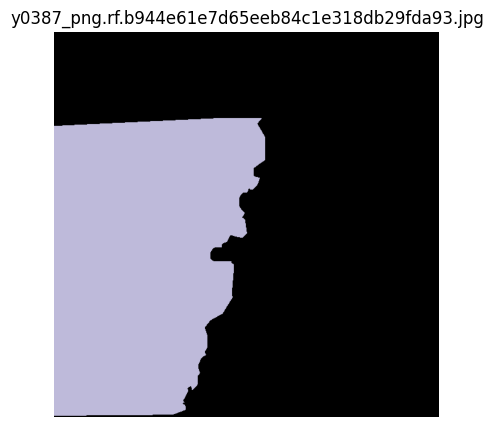

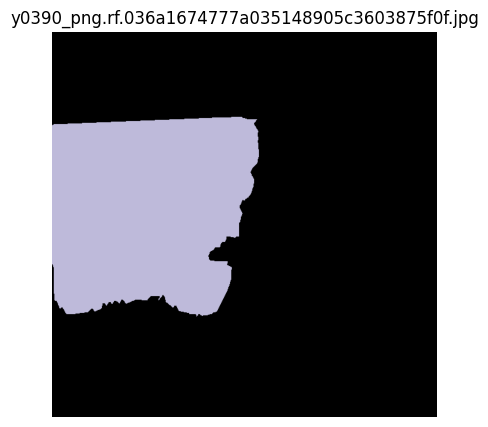

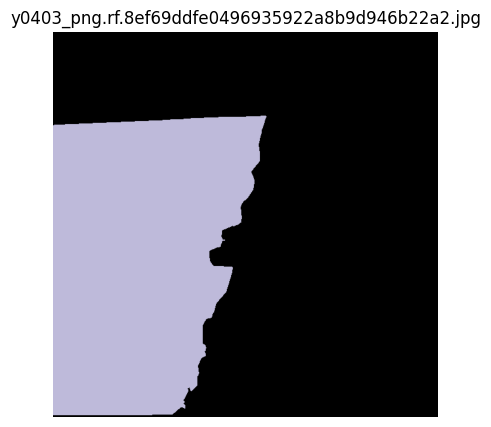

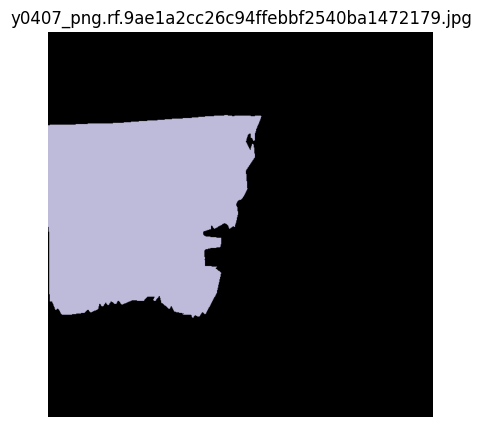

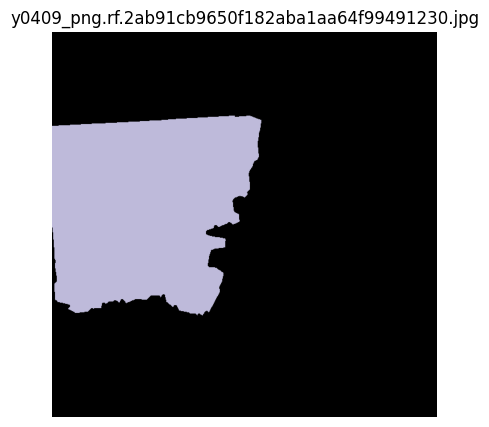

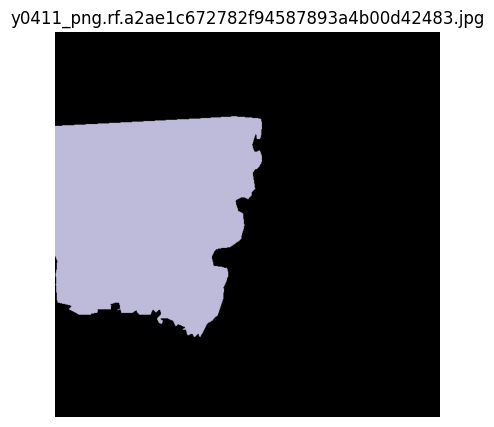

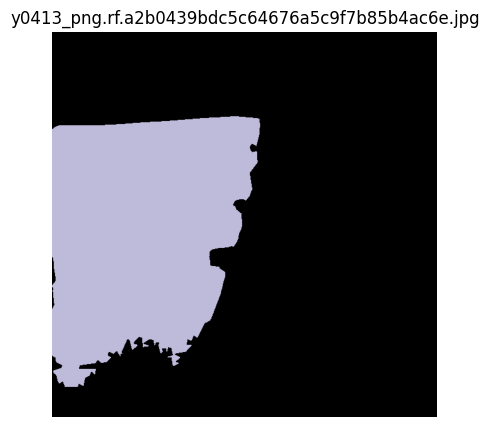

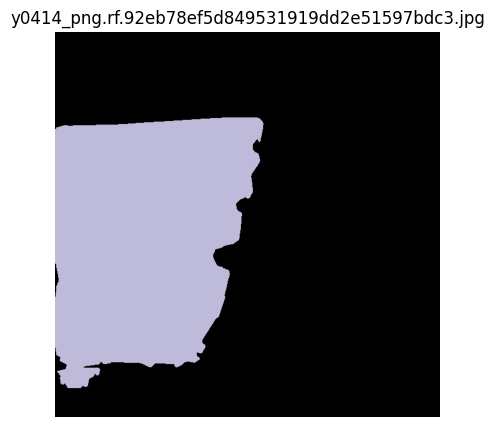

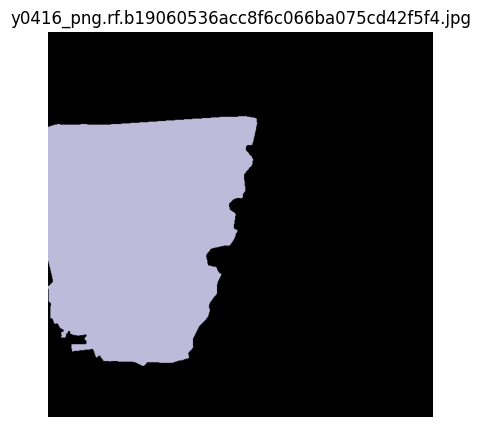

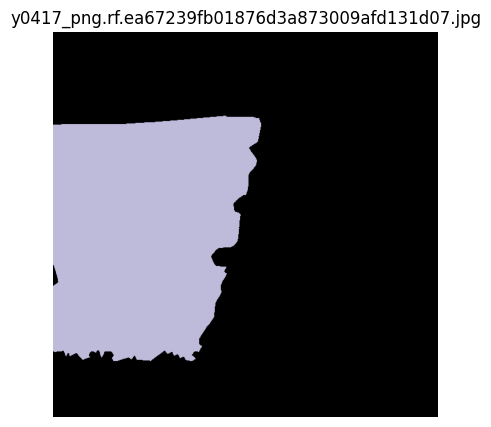

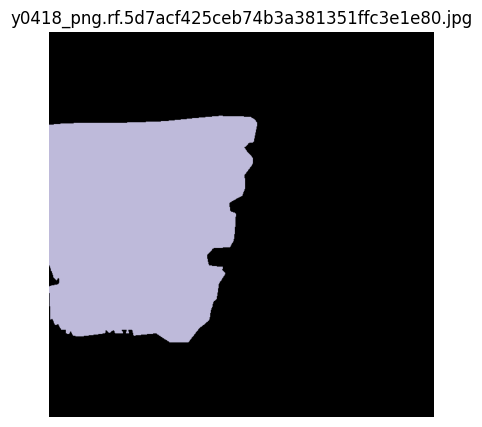

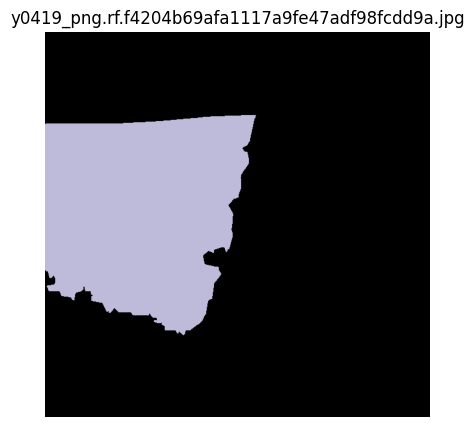

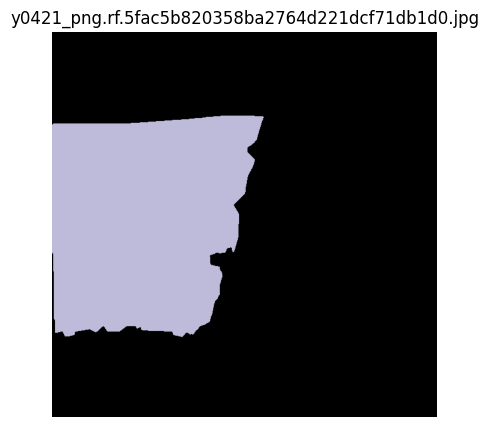

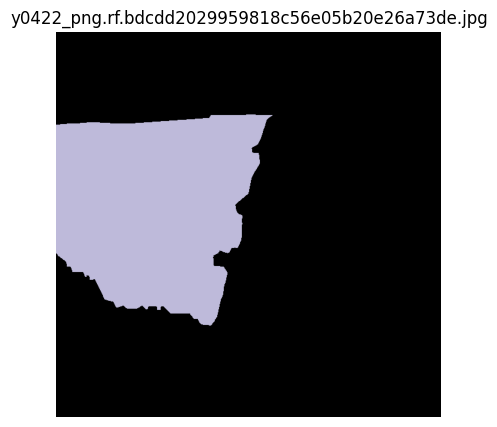

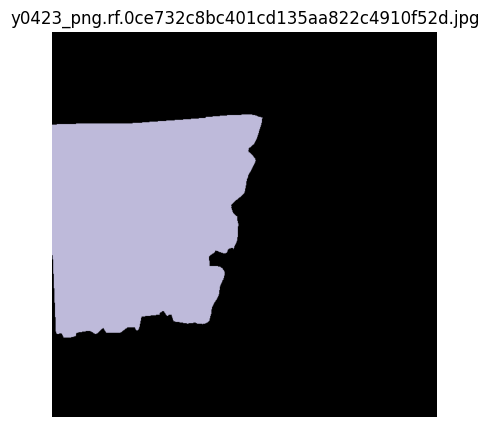

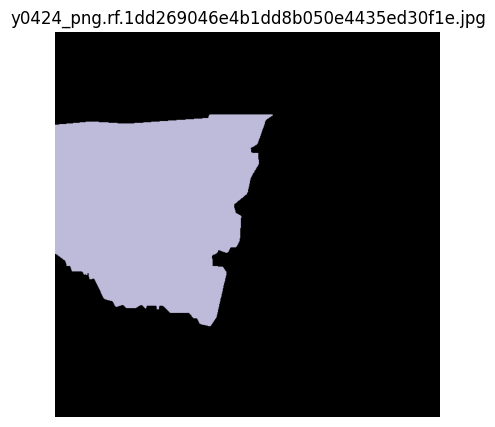

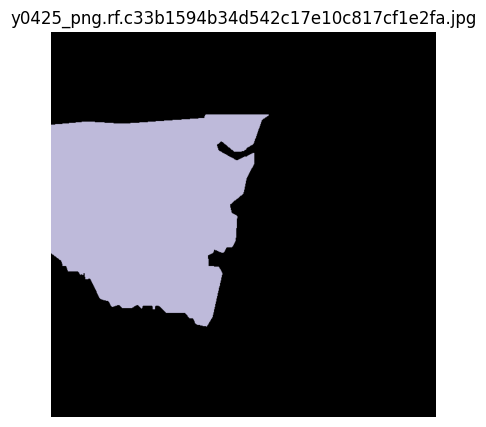

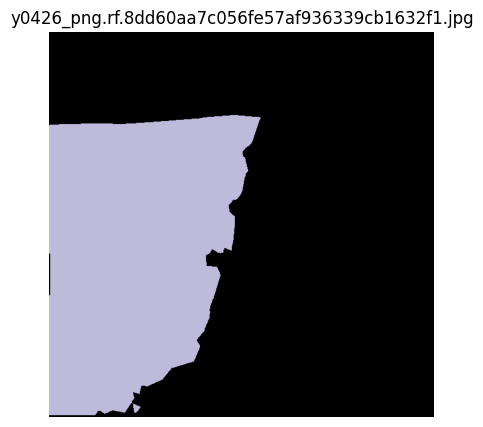

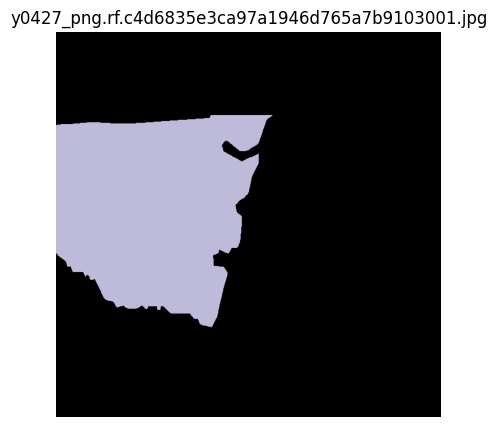

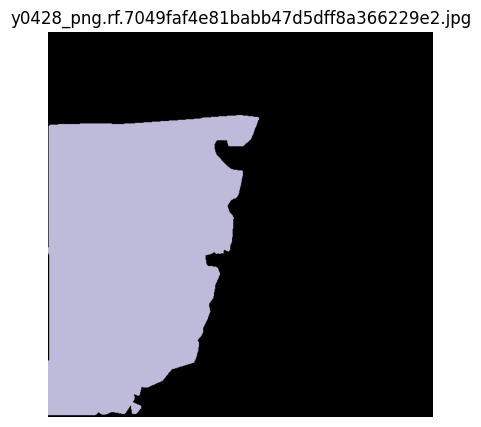

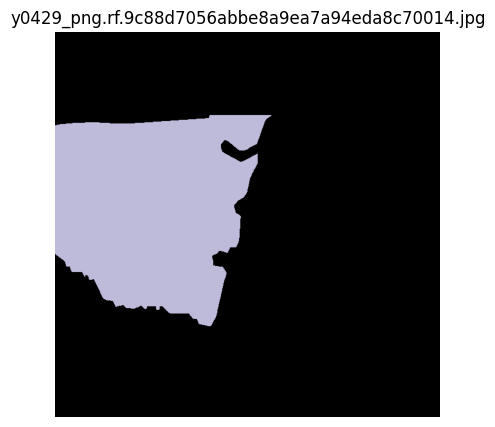

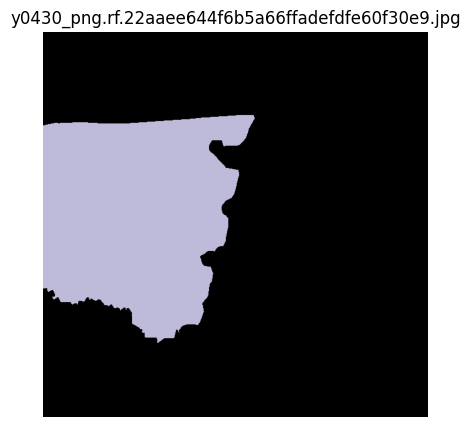

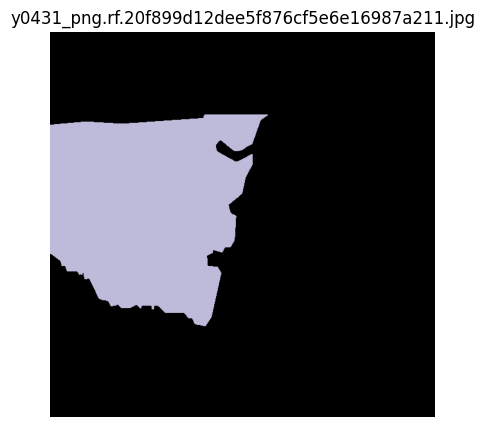

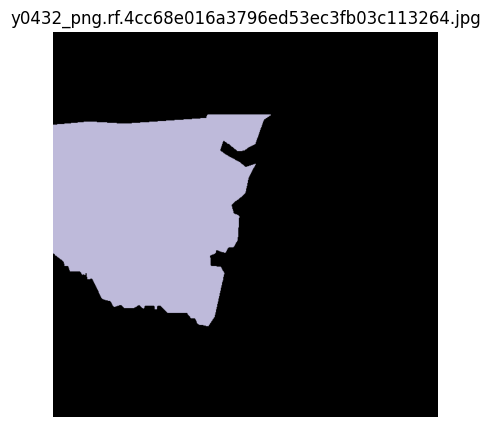

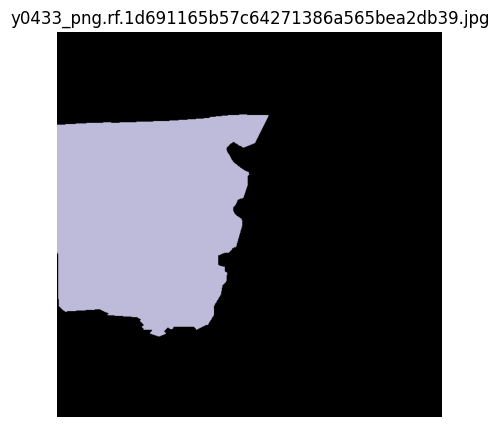

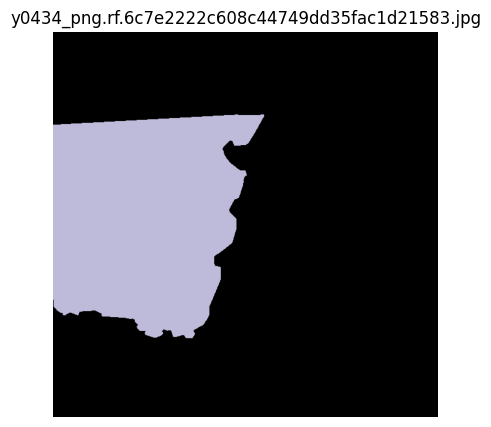

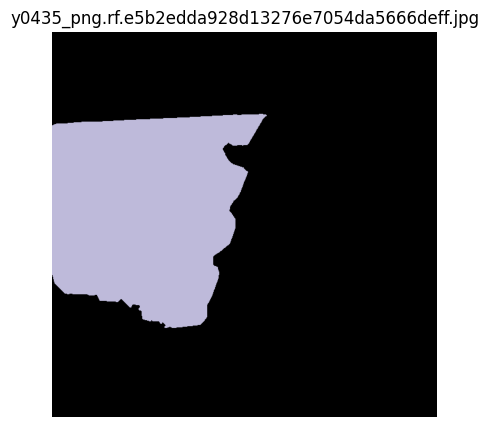

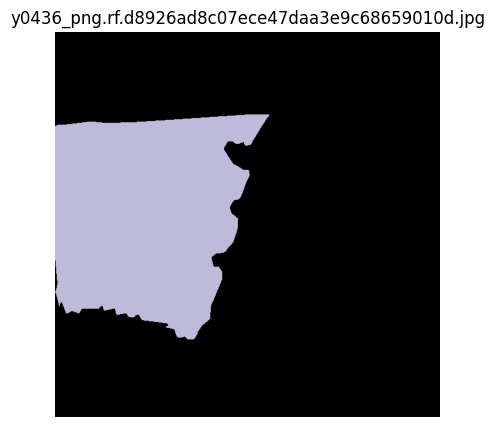

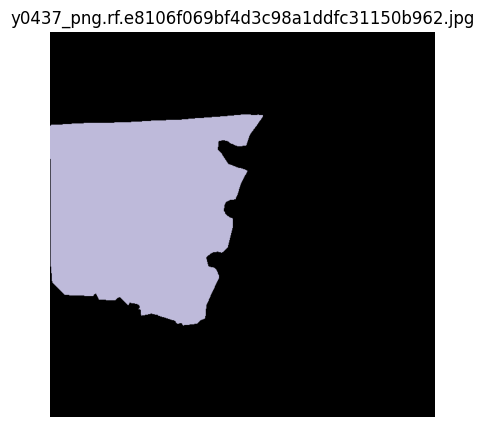

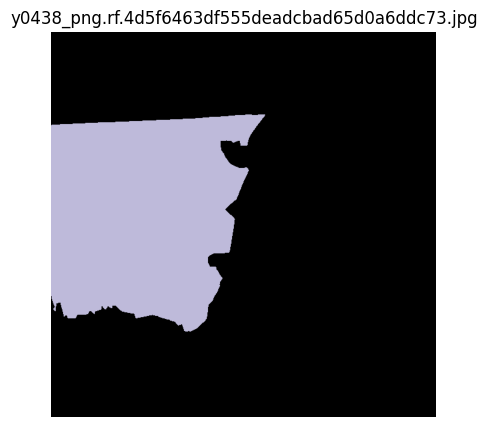

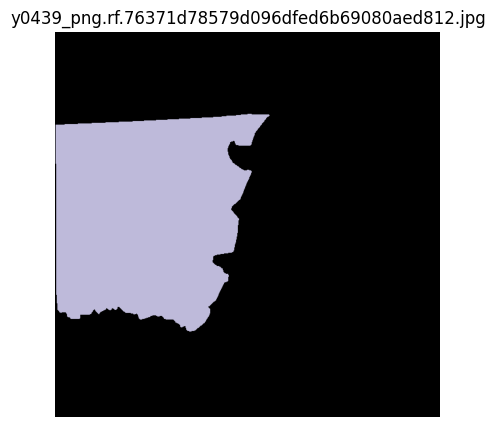

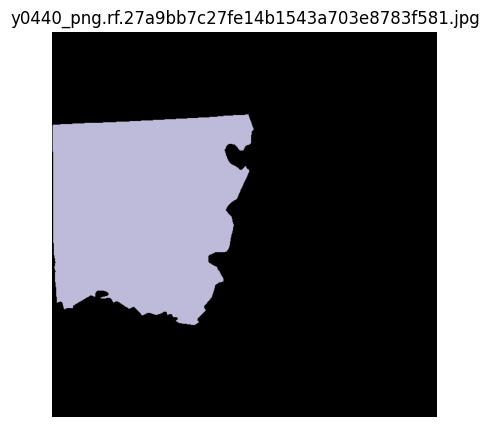

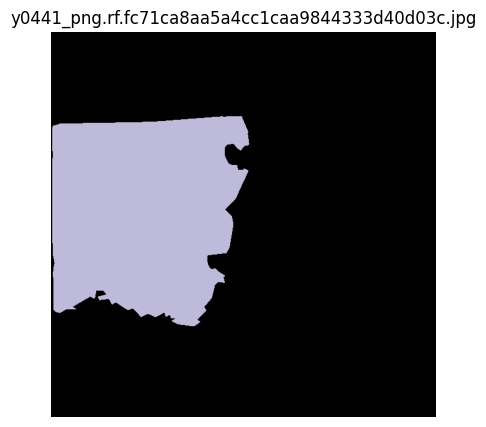

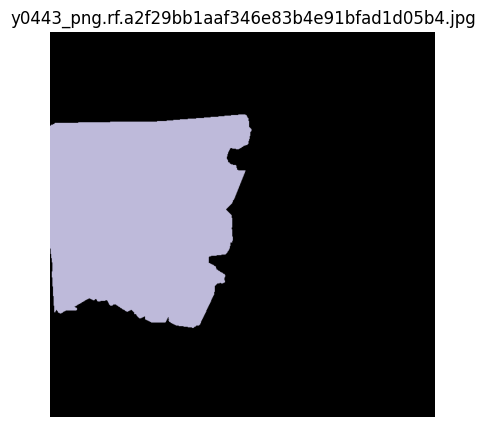

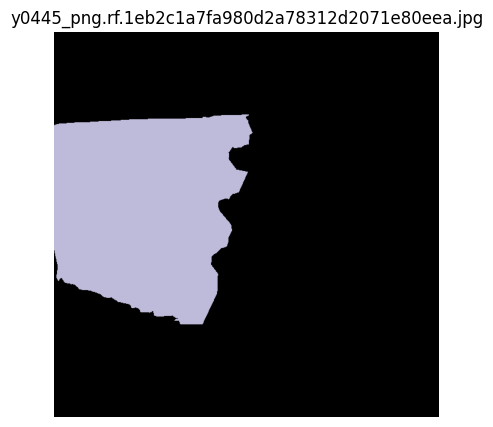

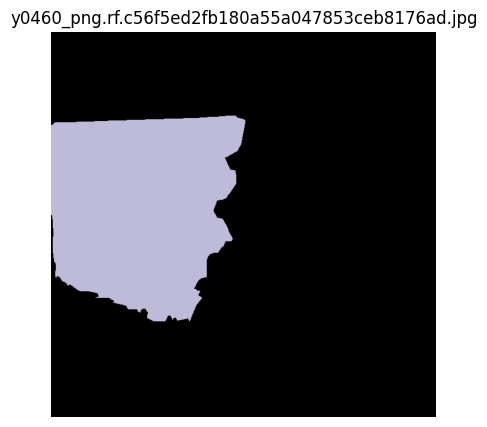

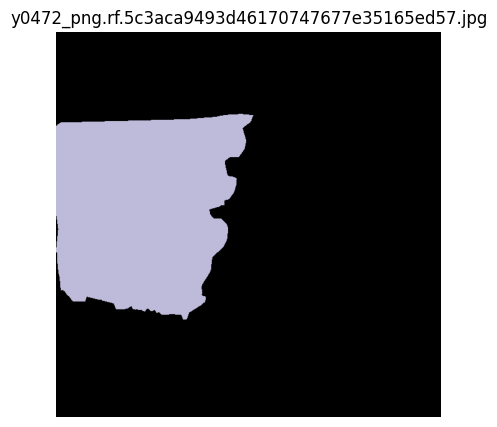

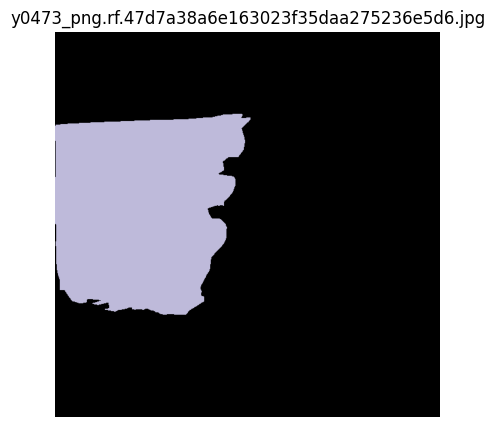

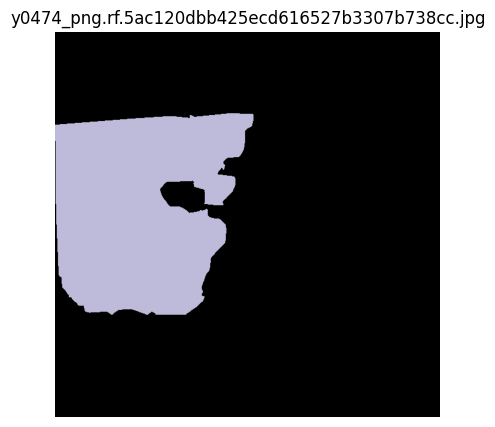

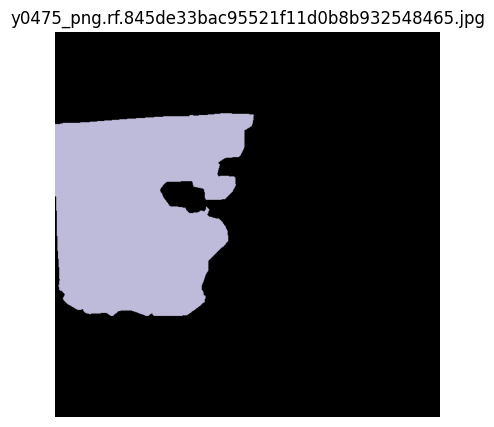

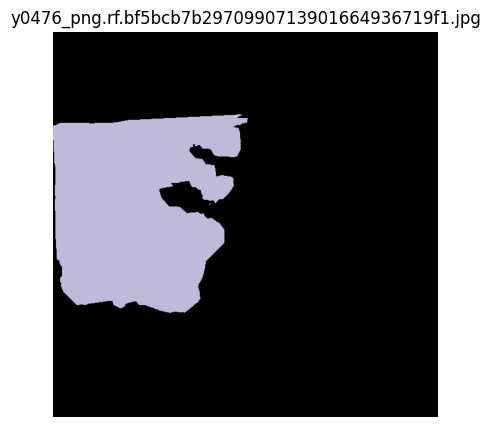

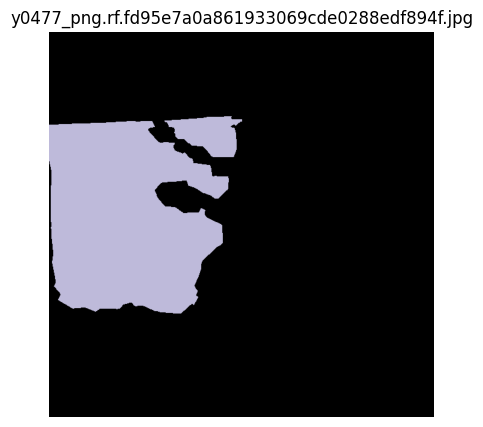

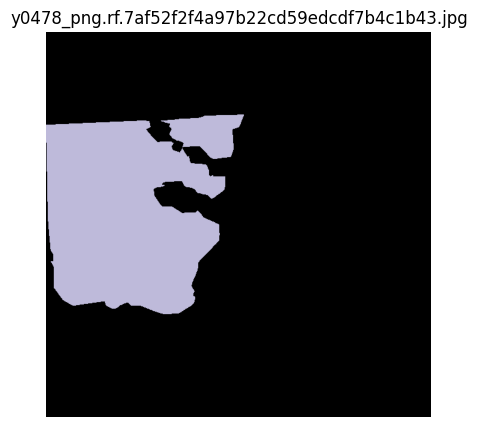

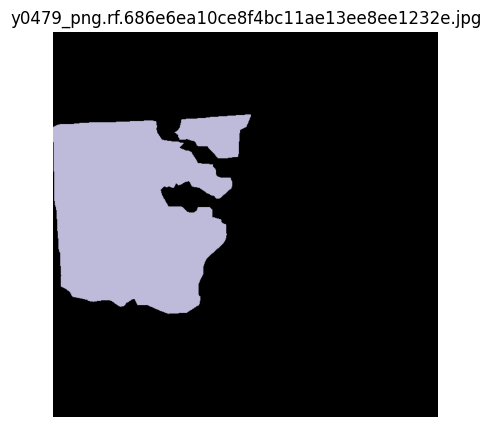

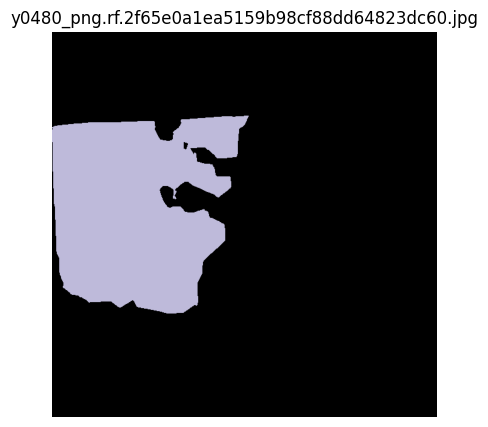

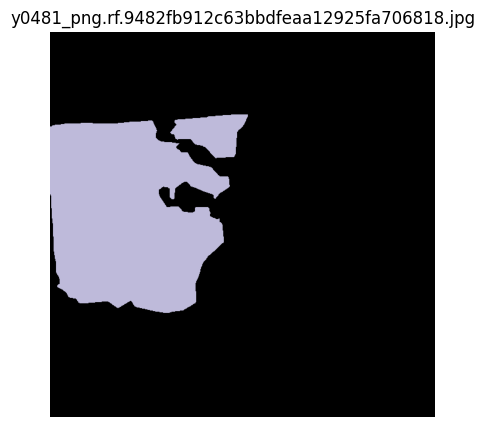

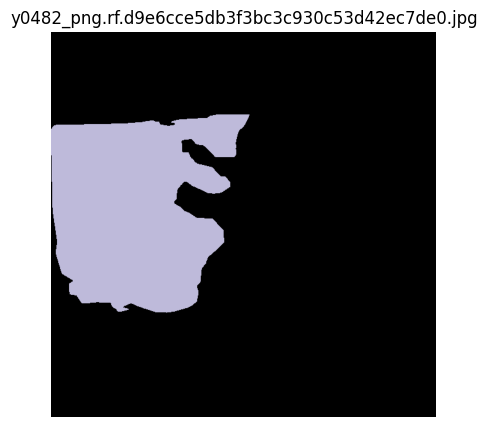

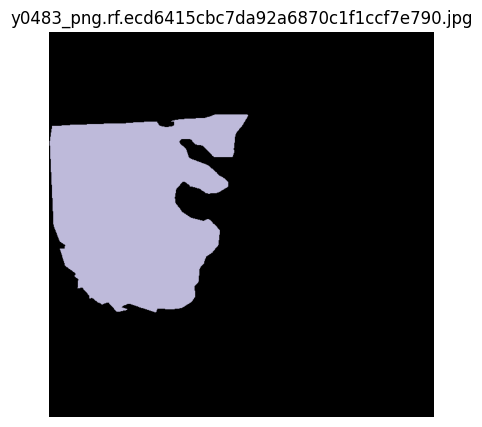

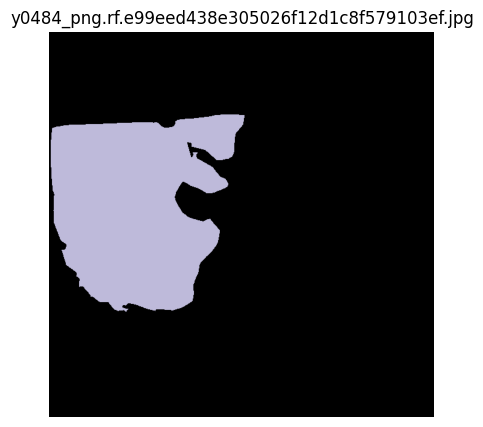

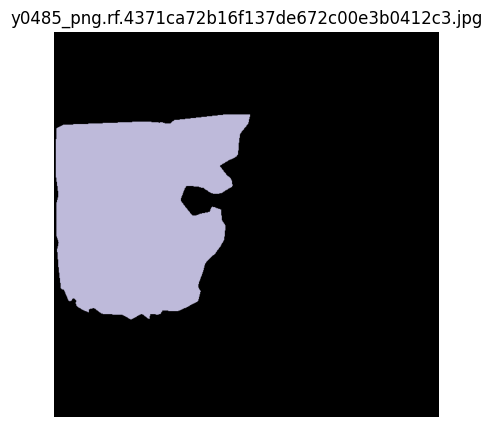

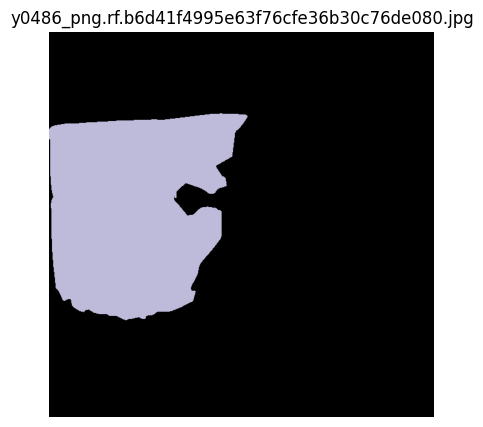

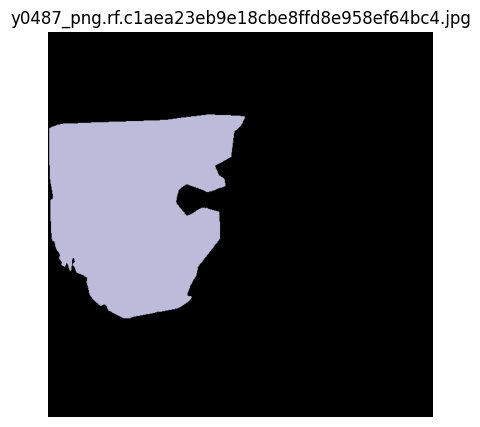

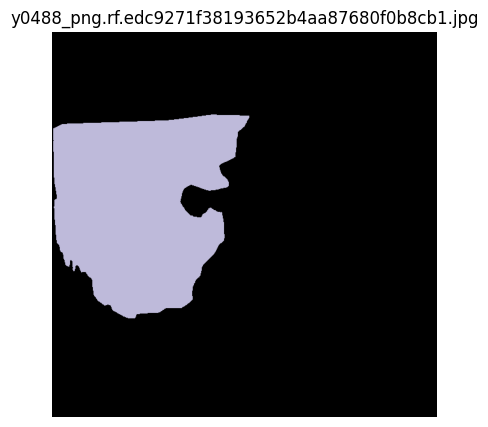

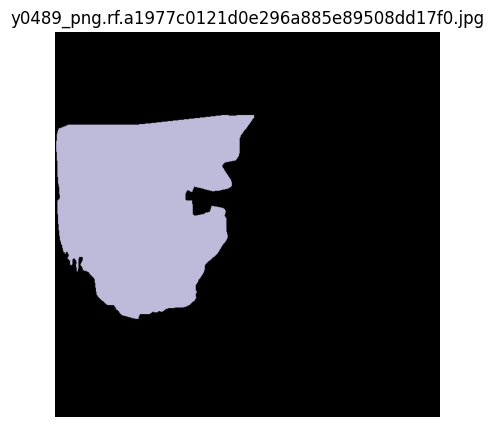

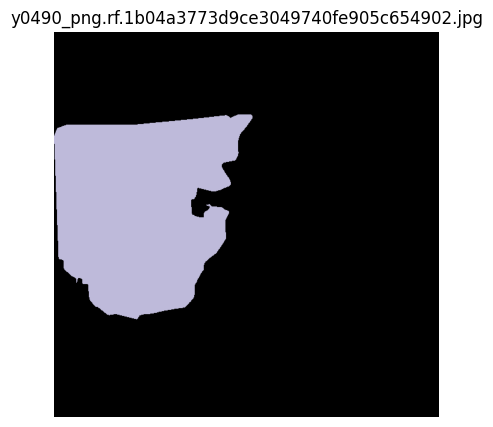

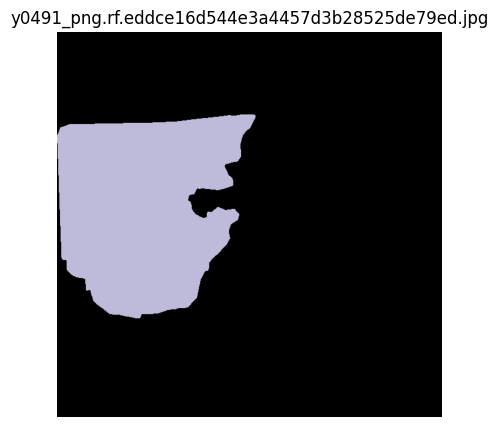

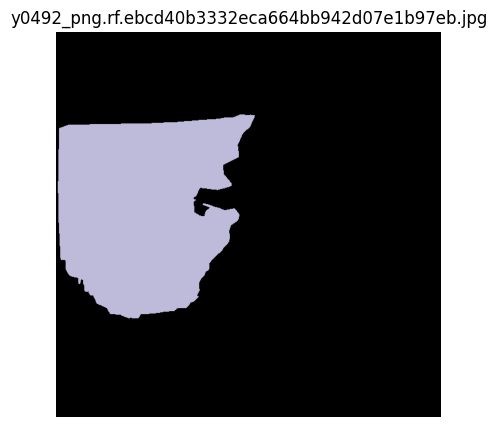

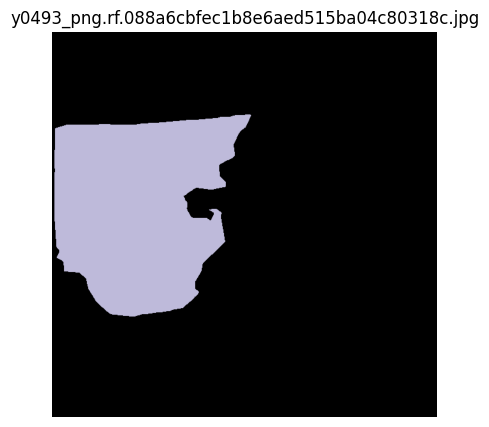

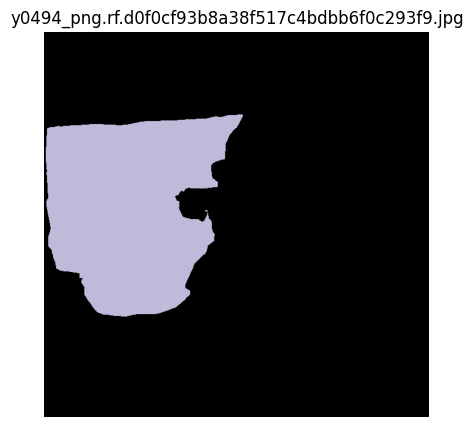

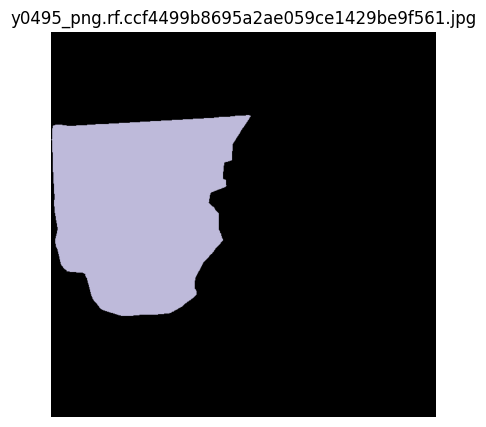

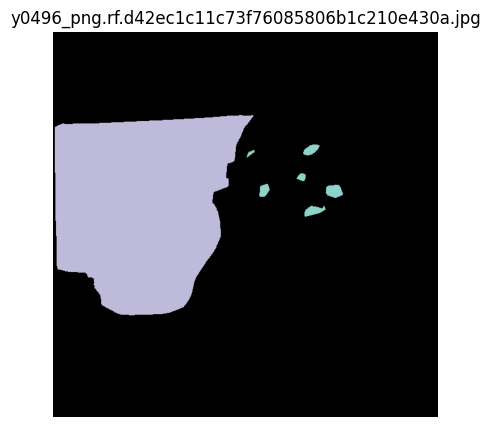

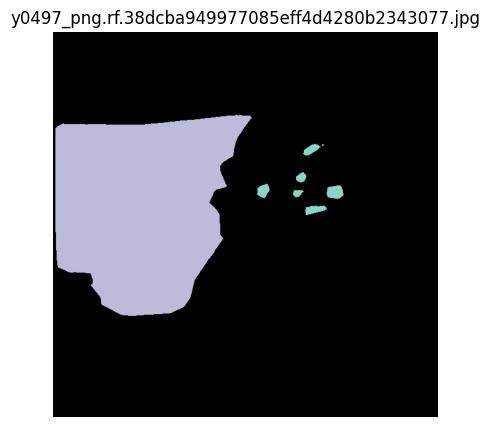

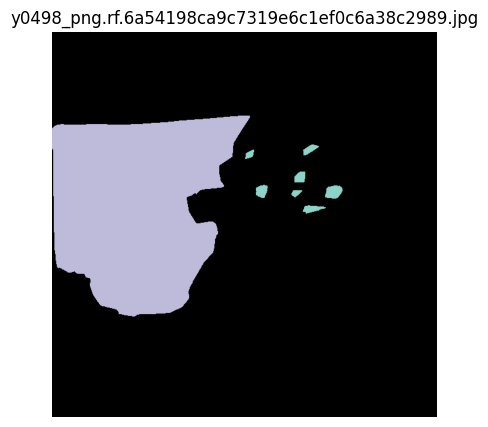

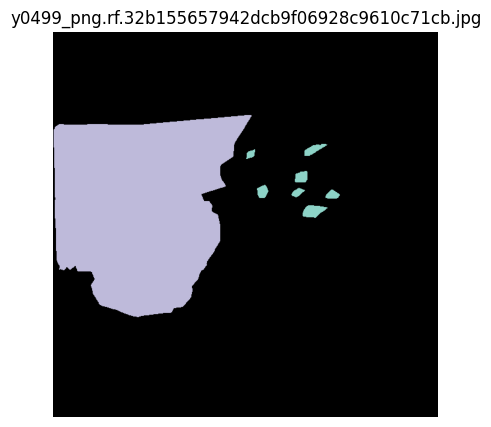

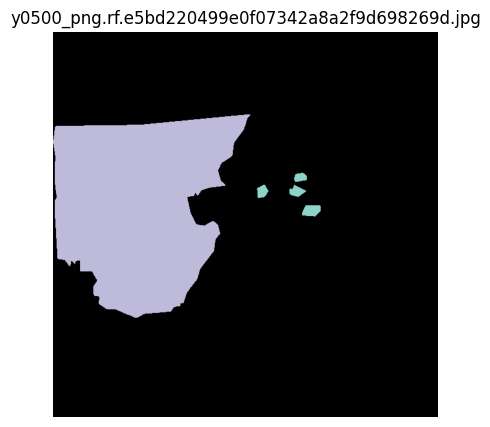

In [ ]:
# @title Combine class masks
output_dir = "/content/final_masks/"
propagate_mask_medsam2.combine_class_masks(indiv_class_masks, output_dir=output_dir, show=True)

# Save as COCO annotation file
export_coco.save_segmentations_as_coco(indiv_class_masks, coco_output_dir="predicted_segmentations_coco.json")

# Save TIFF
export_coco.coco_to_tiff("predicted_segmentations_coco.json", "output_volume.tiff")

In [ ]:
shutil.make_archive('/content/final_masks', 'zip', '/content/final_masks')
files.download("/content/final_masks.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title List all classes and ids
import_data_from_roboflow.get_all_class_name_id()

In [ ]:
# @title Combine class masks
output_dir = "/content/final_masks/"
propagate_mask_medsam2.combine_class_masks(indiv_class_masks, output_dir=output_dir, show=True)

# Save as COCO annotation file
export_coco.save_segmentations_as_coco(indiv_class_masks, coco_output_dir="predicted_segmentations_coco.json")

# Save TIFF
export_coco.coco_to_tiff("predicted_segmentations_coco.json", "output_volume.tiff")


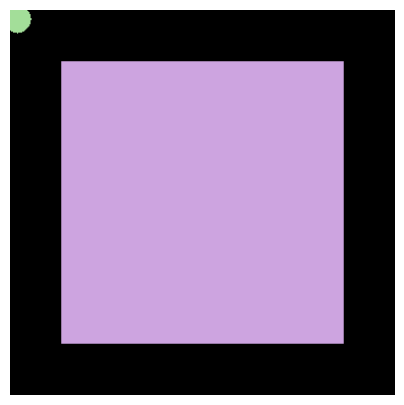

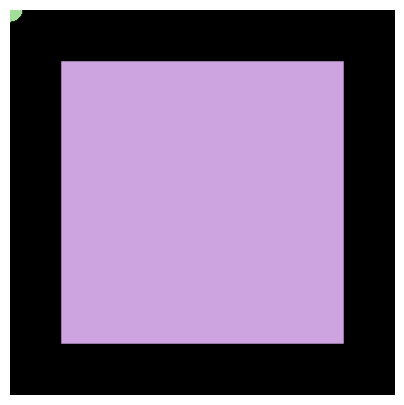

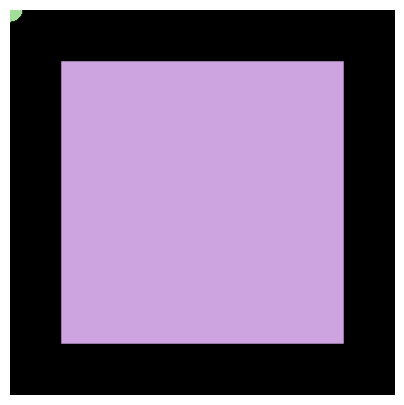

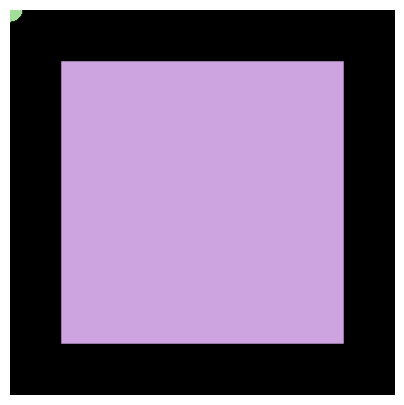

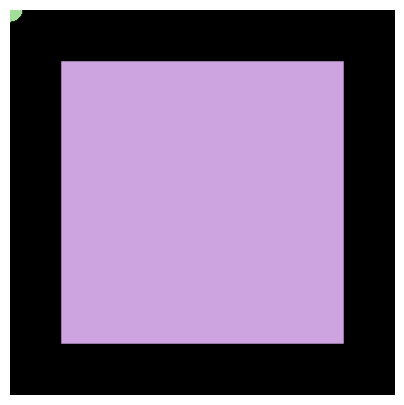

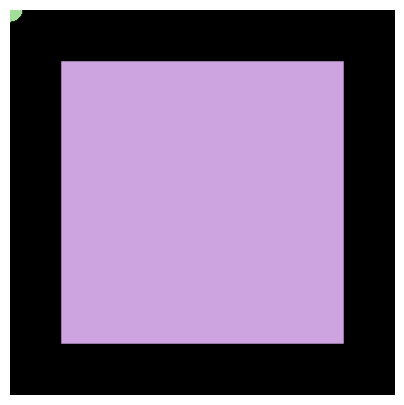

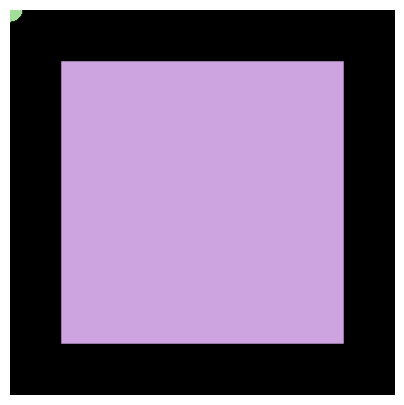

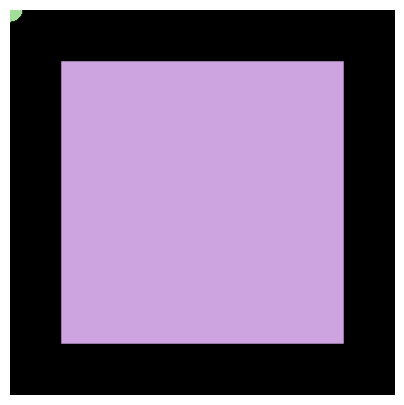

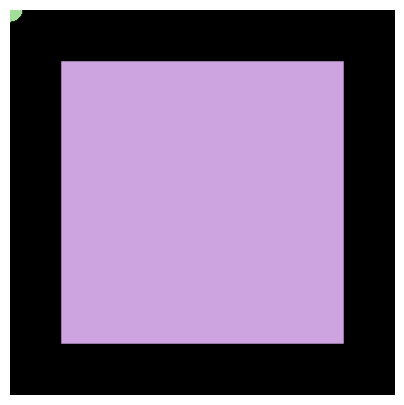

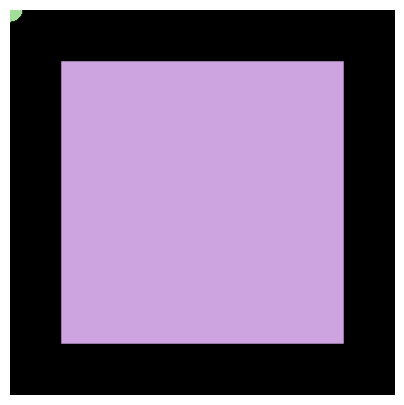

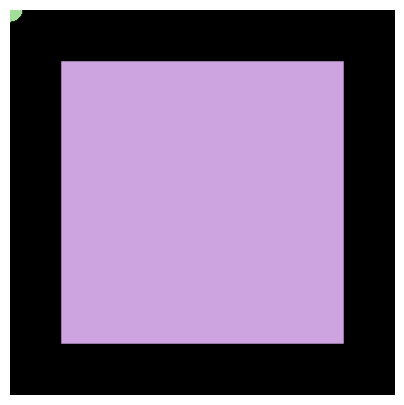

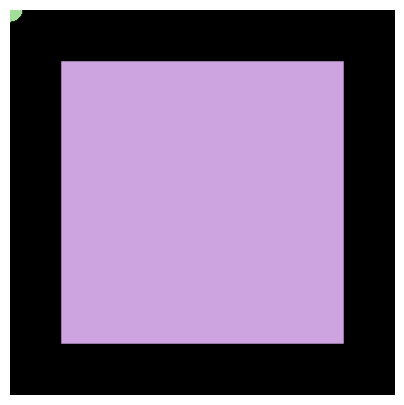

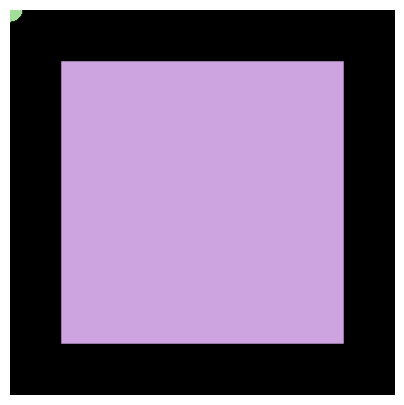

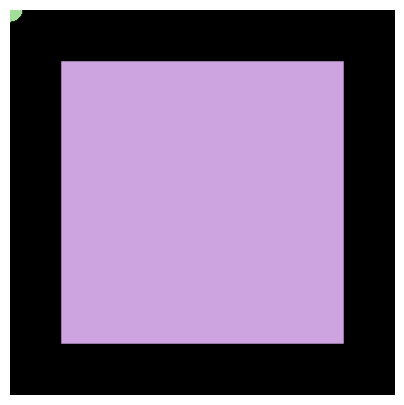

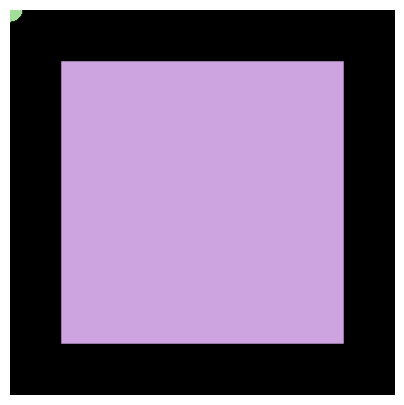

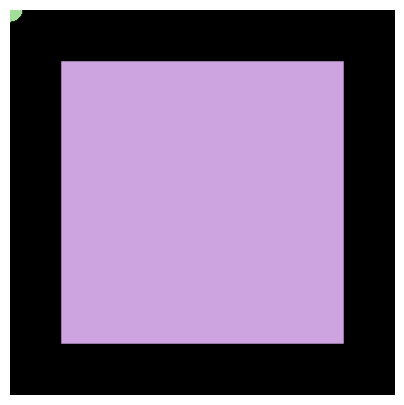

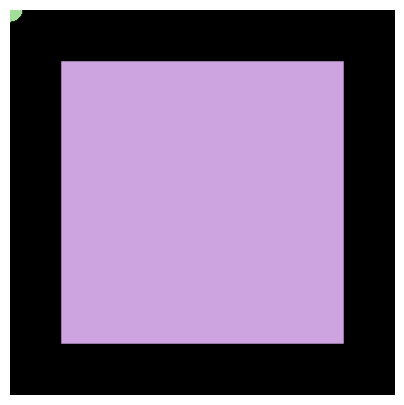

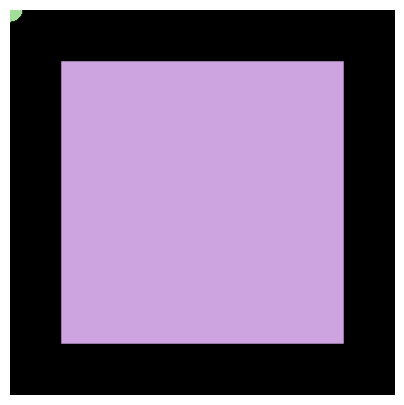

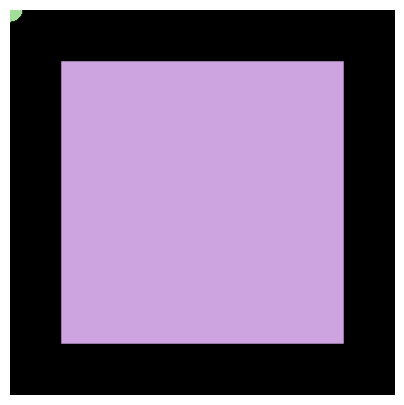

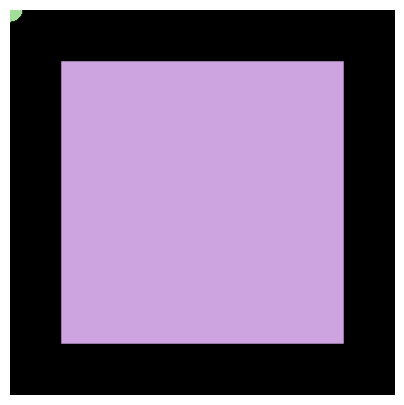

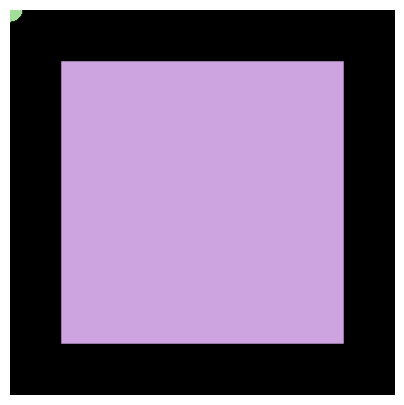

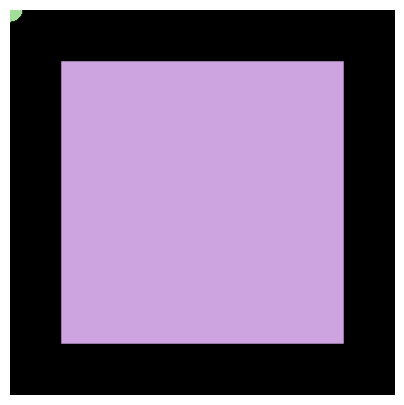

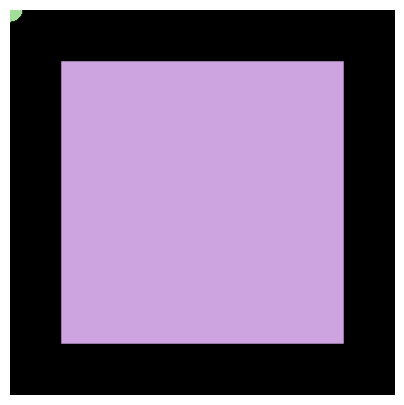

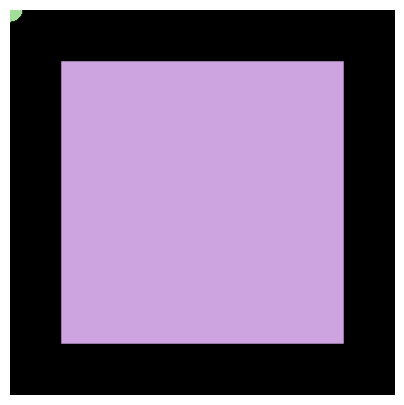

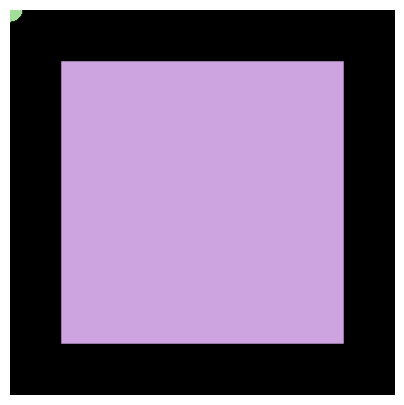

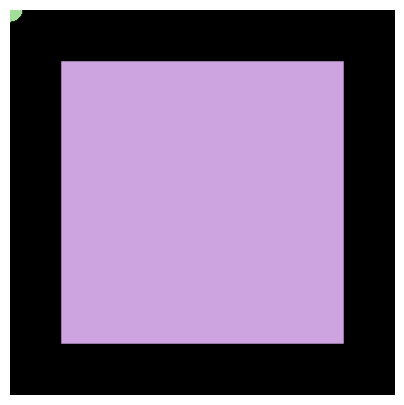

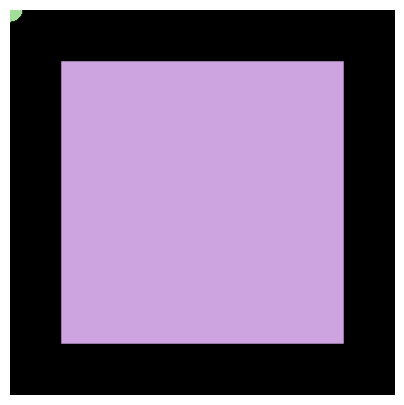

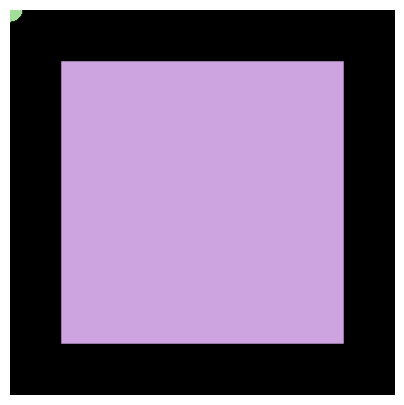

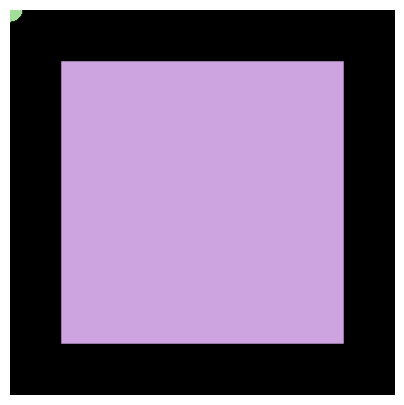

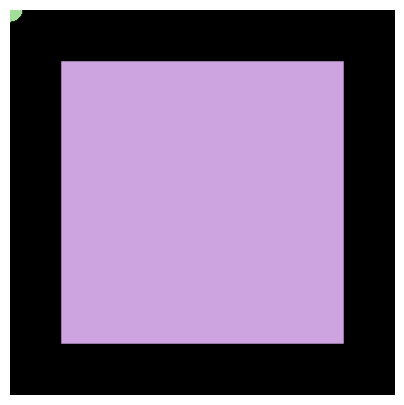

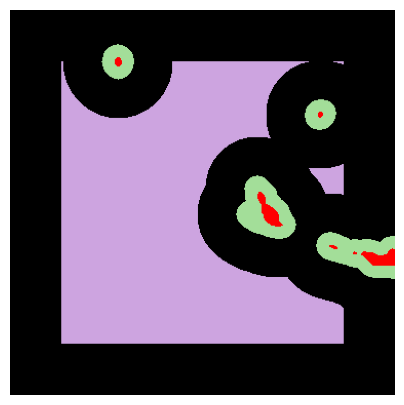

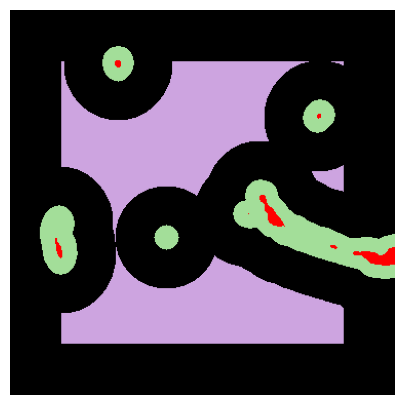

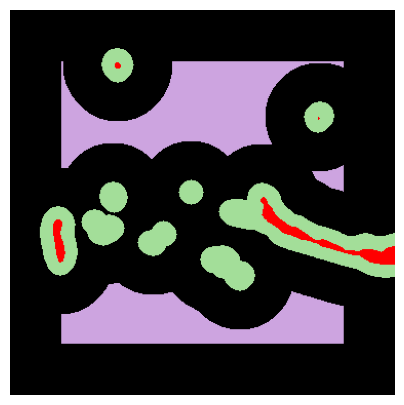

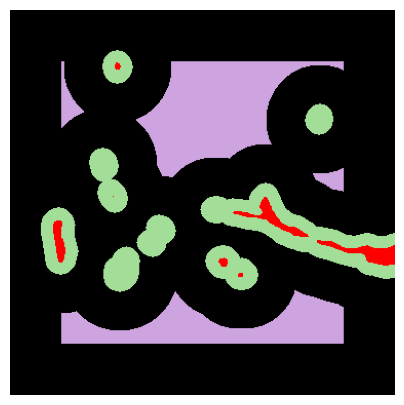

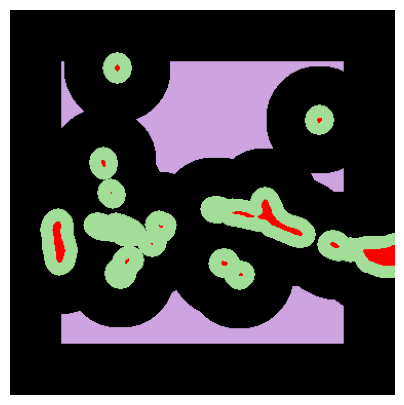

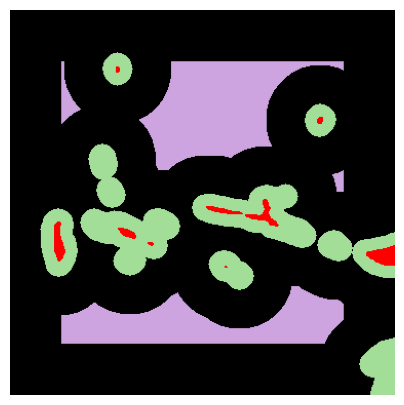

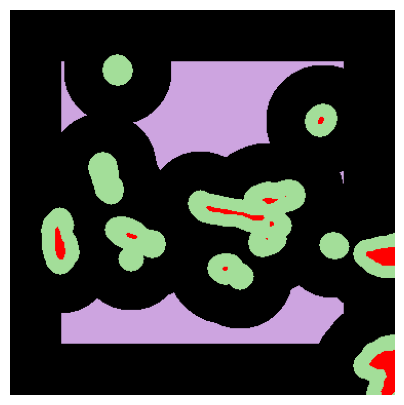

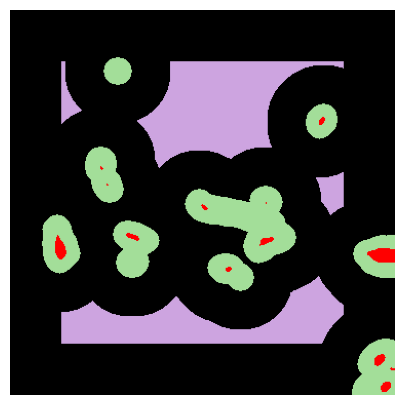

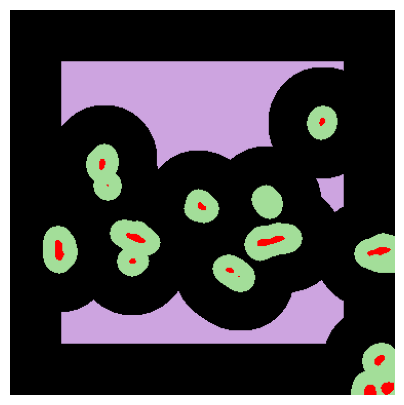

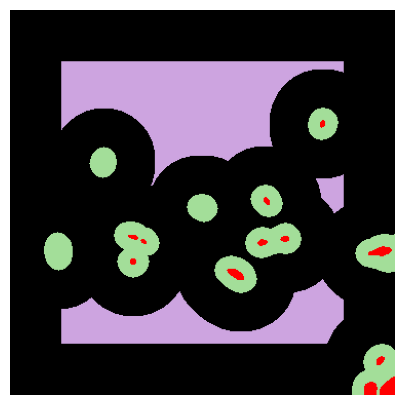

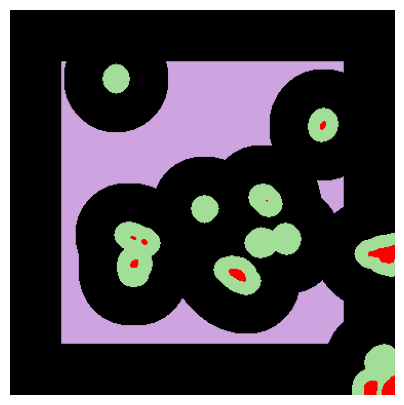

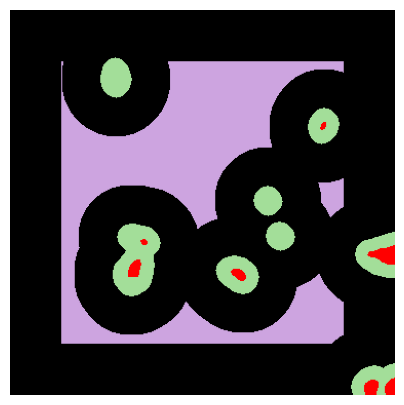

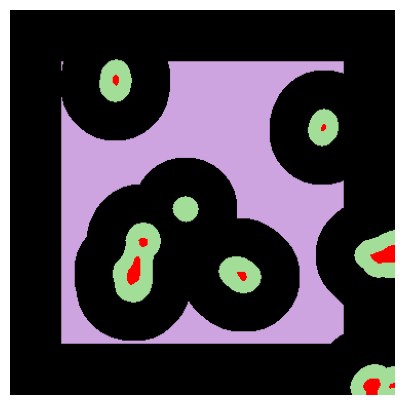

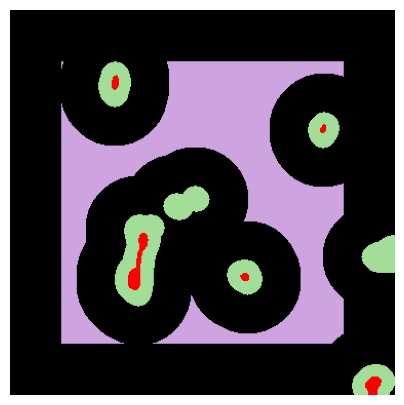

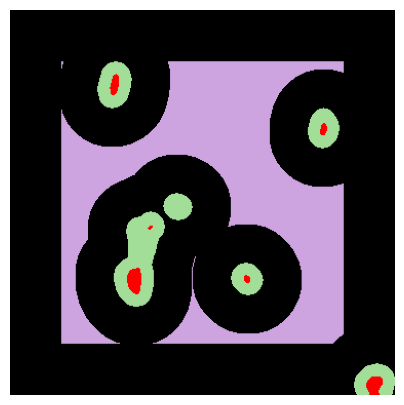

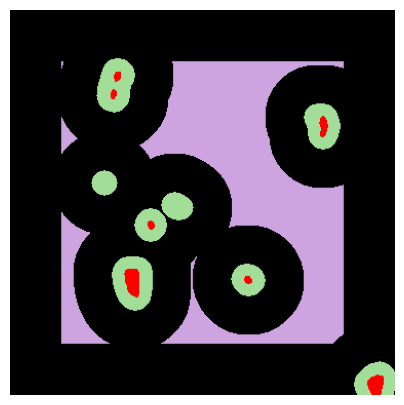

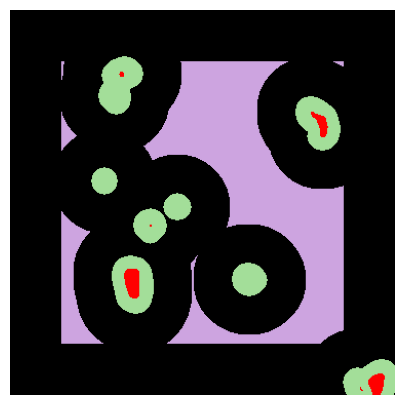

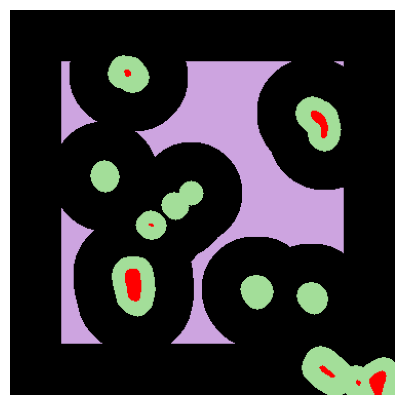

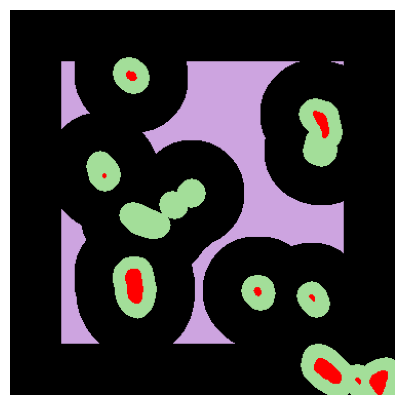

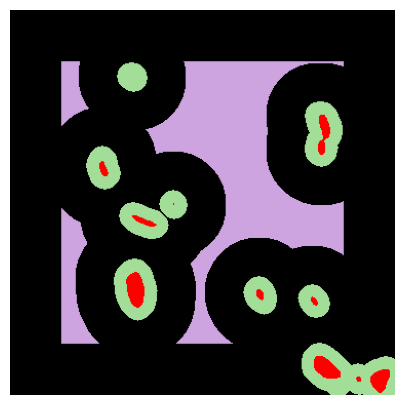

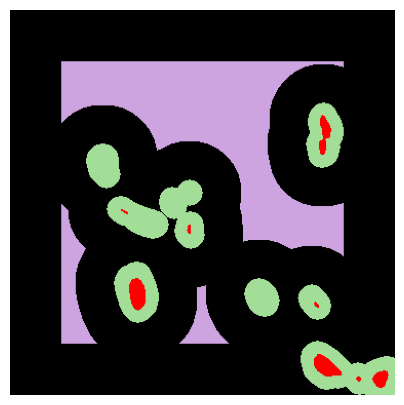

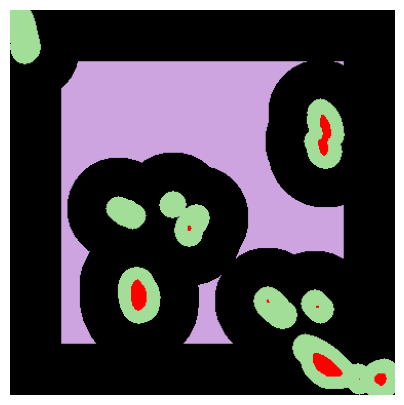

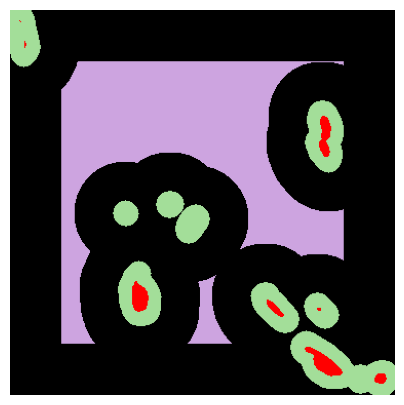

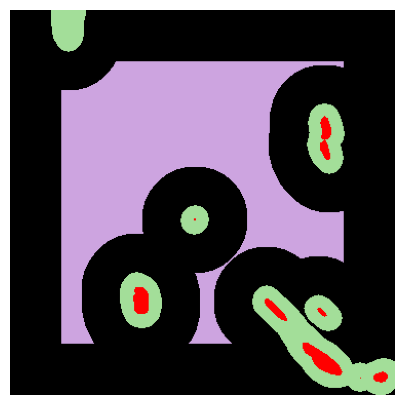

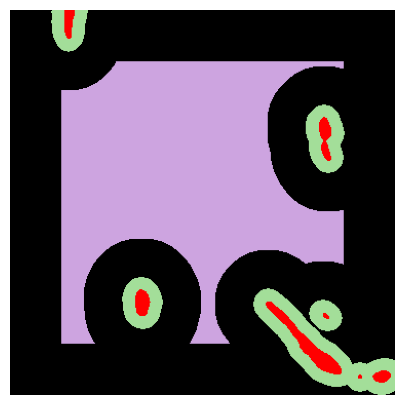

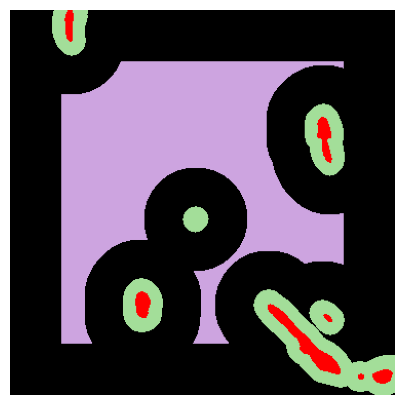

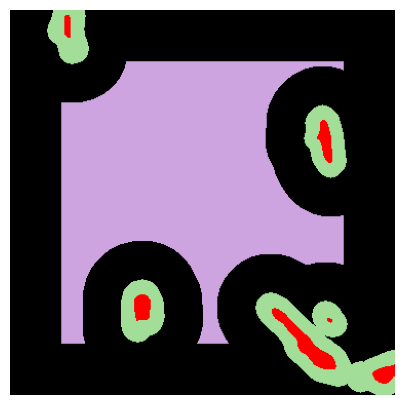

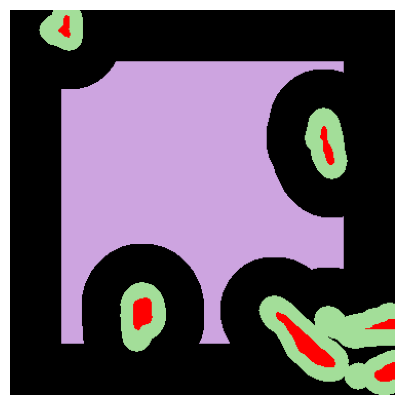

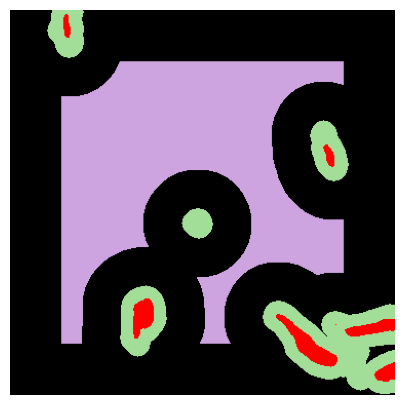

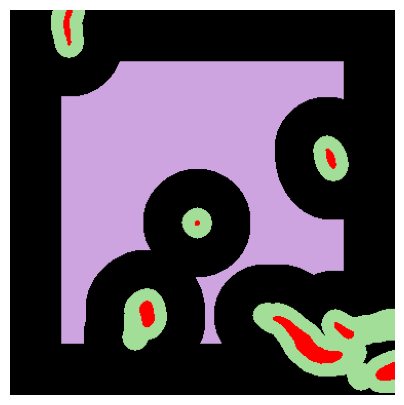

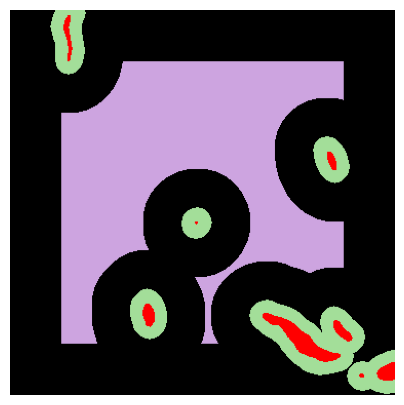

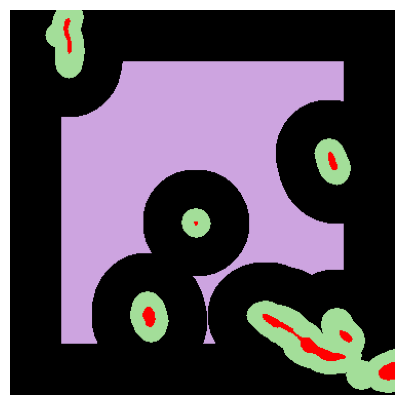

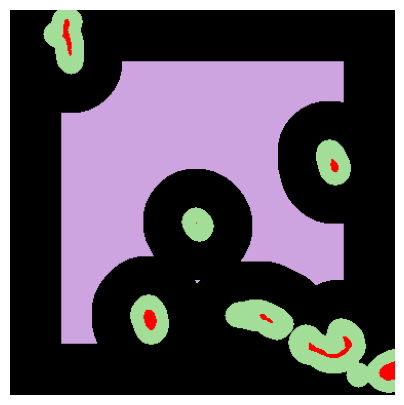

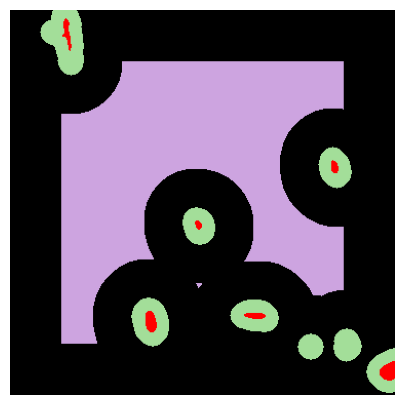

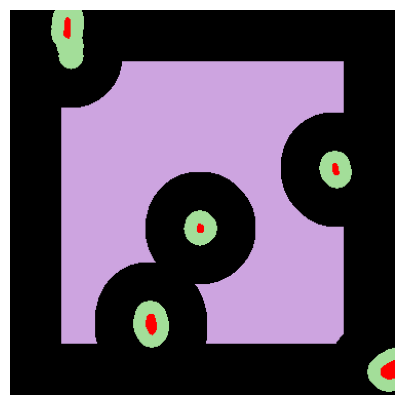

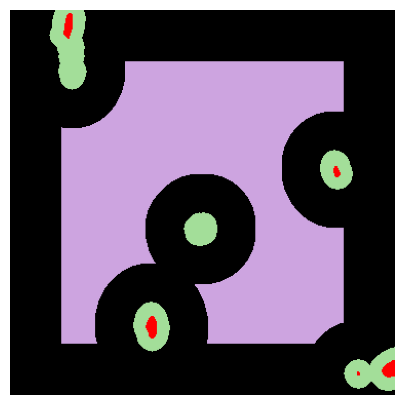

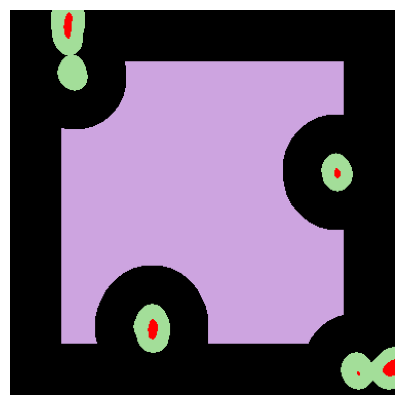

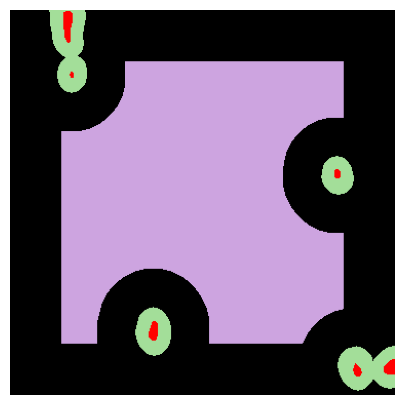

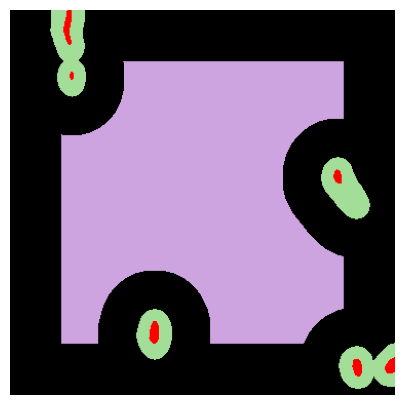

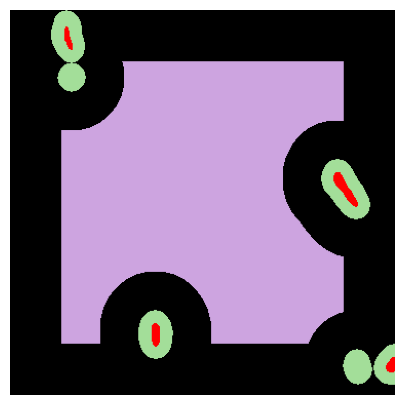

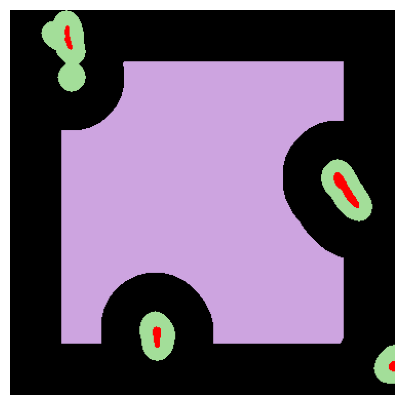

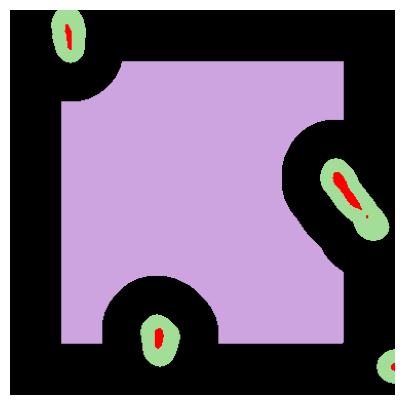

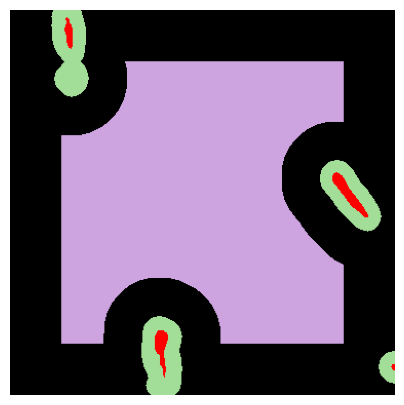

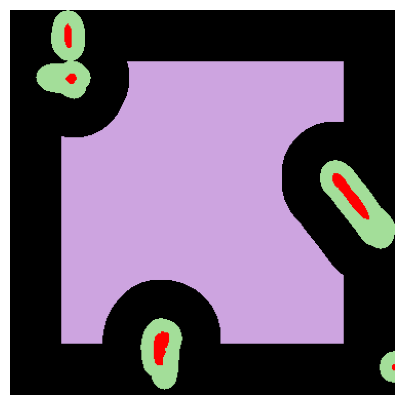

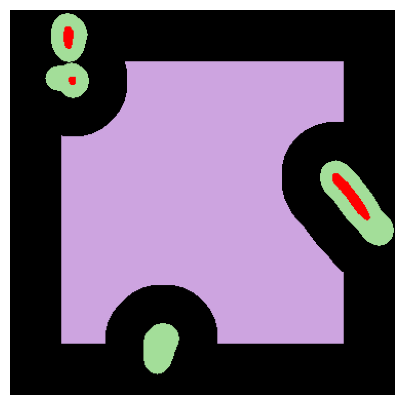

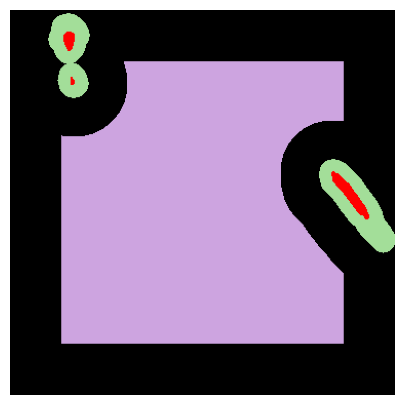

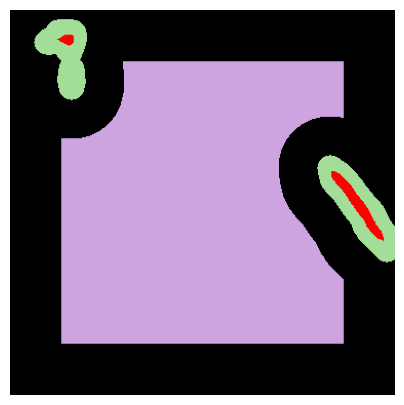

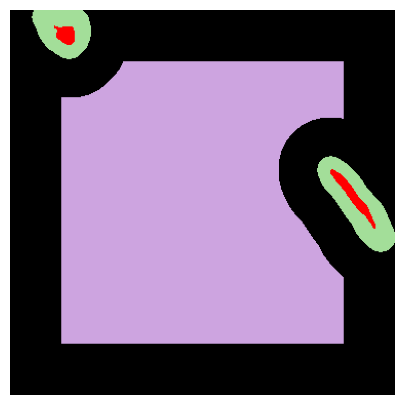

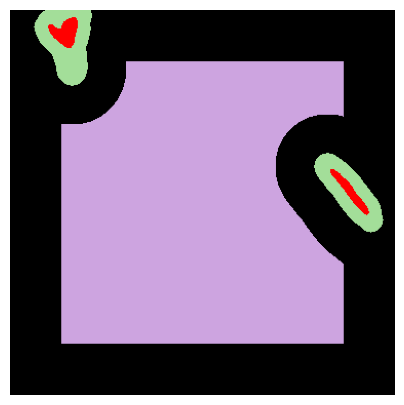

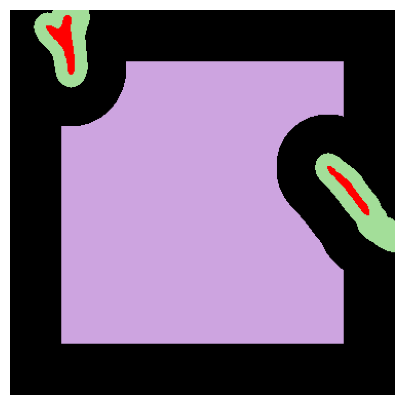

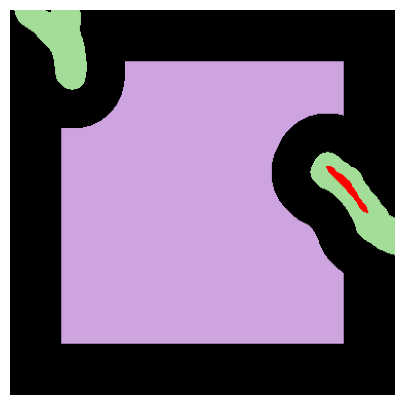

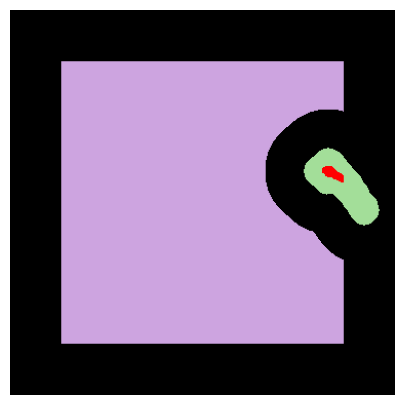

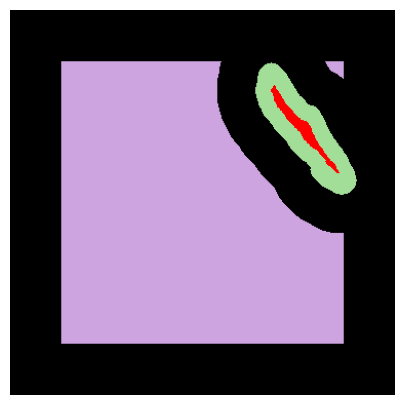

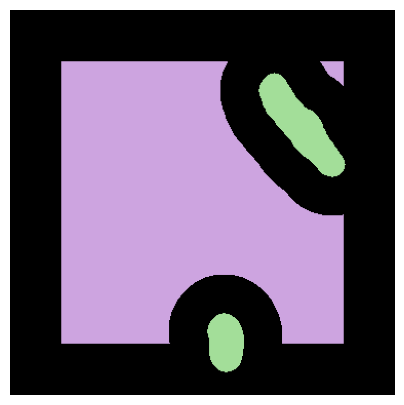

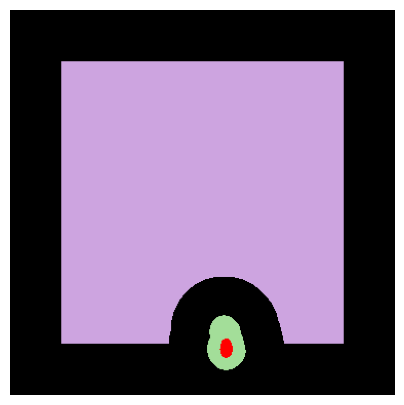

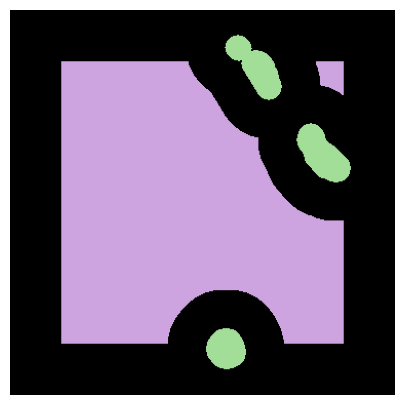

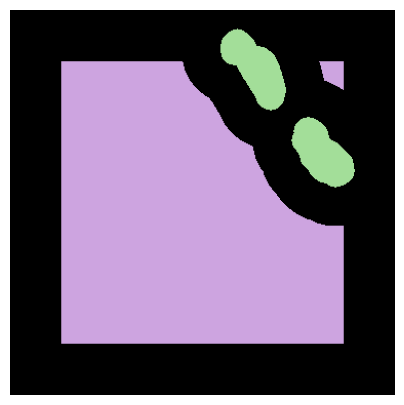

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Save distance thresholded heatmap for blood vessels
heatmap_volume = propagate_mask_medsam2.generate_distance_heatmap(indiv_class_masks[0],
                          distance_threshold_px_near = 50, distance_threshold_px_far = 200, overlay=True, show=True,
                          output_path="/content/distance_threshold_vol.tiff", use_2d_xy_distances=False)

# Save as individual images in a sequence for 3D Viewer
os.makedirs("/content/heatmap_volume_images", exist_ok=True)
for i,v in enumerate(heatmap_volume):
    filename = os.path.join("/content/heatmap_volume_images", f"{i}.tif")
    v = cv2.cvtColor(v, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, v)
shutil.make_archive('/content/heatmap_volume_images', 'zip', '/content/heatmap_volume_images')
files.download("/content/heatmap_volume_images.zip")
